## Paso 0: Importación de las librerias necesarias

In [250]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import cross_val_score
from utils import classification_report
from sklearn.metrics import accuracy_score
from funciones_evaluacion_modelos import evaluation_metrics,plot_residuals,cv_model

## Paso 1: Importación del dataset


Explicación de lo que muestra cada variable del dataset:

1. ExternalRiskEstimate (Estimación de Riesgo Externo): Una medida de la riesgosidad del prestatario basada en fuentes de datos externas consolidadas. Esta variable proporciona una evaluación del riesgo del prestatario utilizando información proveniente de fuentes externas.

2. NetFractionRevolvingBurden (Proporción Neta de Carga Renovable): La proporción del uso actual de crédito de un individuo en comparación con su crédito máximo permitido. Esta variable representa la relación entre la cantidad de crédito que un individuo está utilizando en el momento actual y el límite máximo de crédito disponible para ese individuo.

3. AverageMInFile (Promedio de Meses en el Archivo): La duración promedio, en meses, de las operaciones en el archivo de crédito de un prestatario. Esta variable indica la duración promedio de las operaciones de crédito presentes en el archivo de crédito de un prestatario.

4. MSinceOldestTradeOpen (Meses Desde la Apertura del Comercio Más Antiguo): La antigüedad, en meses, de la cuenta de crédito más antigua de un prestatario. Esta variable representa la edad de la cuenta de crédito más antigua en el historial crediticio de un prestatario.

5. PercentInstallTrades (Porcentaje de Operaciones de Instalación): El porcentaje de las cuentas de crédito de un prestatario que tienen términos de pago fijos durante un período especificado. Esta variable indica la proporción de las cuentas de crédito de un prestatario que tienen términos de pago fijos en comparación con el total de cuentas de crédito.

6. NumSatisfactoryTrades (Número de Operaciones Satisfactorias): El número de operaciones donde un prestatario ha cumplido satisfactoriamente con sus obligaciones. Esta variable representa la cantidad de operaciones crediticias en las que un prestatario ha cumplido satisfactoriamente con sus obligaciones.

7. NumTotalTrades (Número Total de Operaciones): El número total de operaciones crediticias (número total de cuentas de crédito) asociadas con un prestatario. Esta variable indica la cantidad total de cuentas de crédito que un prestatario tiene en su historial crediticio.

8. MSinceMostRecentInqexcl7days (Meses Desde la Consulta Más Reciente Excluyendo 7 Días): Meses transcurridos desde la última consulta de crédito, excluyendo la semana más reciente. Esta variable representa la antigüedad de la última consulta de crédito, excluyendo las consultas realizadas durante la semana más reciente.

9. PercentTradesNeverDelq (Porcentaje de Operaciones sin Incumplimientos): El porcentaje de las operaciones crediticias de un prestatario que no tienen historial de incumplimiento. Esta variable indica la proporción de las operaciones crediticias de un prestatario que no tienen registros de incumplimiento.

Variable de Salida:

10. Risk Performance (Rendimiento de Riesgo): Indicador de si el prestatario ha pagado según lo acordado (12-36 meses). Variable de clase: 0 ('Bueno') o 1 ('Malo'). Esta variable representa el rendimiento del riesgo del prestatario y clasifica si el prestatario ha pagado de acuerdo con los términos acordados durante un período específico (12-36 meses), con valores binarios indicando si el rendimiento es 'Bueno' o 'Malo'.

In [251]:
df = pd.read_csv("FICO_Dataset.csv", sep = ";")
print(df.head())
output = "RiskPerformance"
inputs = list(df)[1:]

   RiskPerformance  ExternalRiskEstimate  NetFractionRevolvingBurden  \
0              1.0                    55                          33   
1              1.0                    61                           0   
2              1.0                    67                          53   
3              1.0                    66                          72   
4              1.0                    81                          51   

   AverageMInFile  MSinceOldestTradeOpen  PercentTradesWBalance  \
0              84                  144.0                   69.0   
1              41                   58.0                    0.0   
2              24                   66.0                   86.0   
3              73                  169.0                   91.0   
4             132                  333.0                   80.0   

   PercentInstallTrades  NumSatisfactoryTrades  NumTotalTrades  \
0                    43                   20.0            23.0   
1                    67         

<AxesSubplot: >

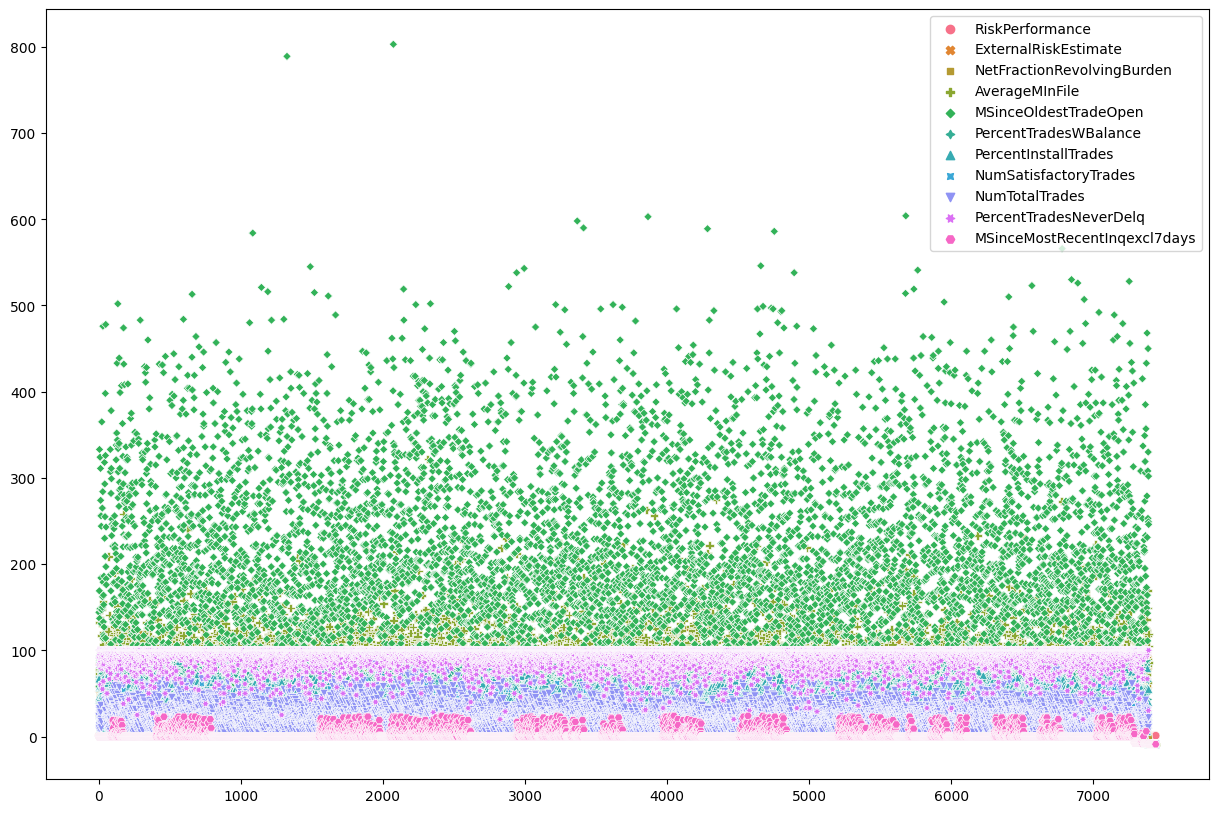

In [252]:
plt.figure(figsize=(15,10))
sns.scatterplot(df)

<AxesSubplot: ylabel='RiskPerformance'>

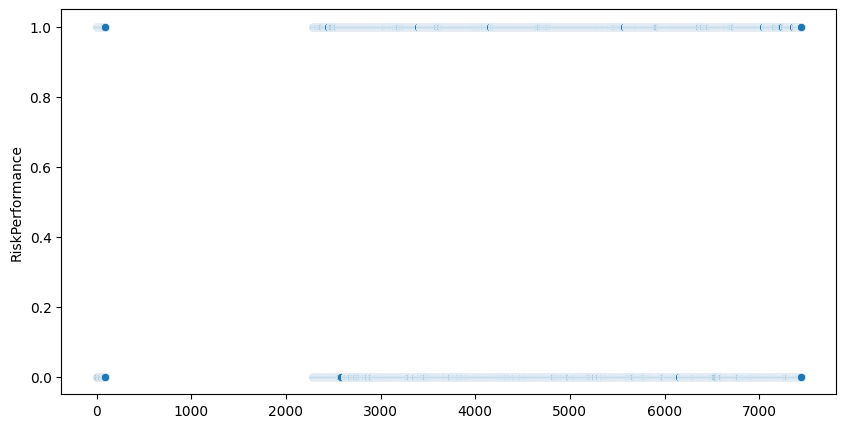

In [253]:
plt.figure(figsize=(10,5))
sns.scatterplot(df[output])

Viendo la distribución del input, podemos concretar que estamos ante un problema de clasificación, pues nuestra variable output posee unicamente 2 etiqueta 0 o 1. Nuestro objetivo será poder clasificar correctamente los puntos del dataset, para ello usaremos modelos como KNN en la parte 2 que nos ayudarán en el proceso.

## Paso 2: Estudio de valores faltantes

In [254]:
for var in list(df):
    print(df[var].isna().value_counts())
    print("\n")

False    5245
True     2197
Name: RiskPerformance, dtype: int64


False    7442
Name: ExternalRiskEstimate, dtype: int64


False    7442
Name: NetFractionRevolvingBurden, dtype: int64


False    7442
Name: AverageMInFile, dtype: int64


False    7415
True       27
Name: MSinceOldestTradeOpen, dtype: int64


False    7386
True       56
Name: PercentTradesWBalance, dtype: int64


False    7442
Name: PercentInstallTrades, dtype: int64


False    7425
True       17
Name: NumSatisfactoryTrades, dtype: int64


False    7419
True       23
Name: NumTotalTrades, dtype: int64


False    7442
Name: PercentTradesNeverDelq, dtype: int64


False    7442
Name: MSinceMostRecentInqexcl7days, dtype: int64




Viendo que sobretodo hay una gran cantidad de datos faltantes en la columna output, vamos a eliminar estos del tirón, ya que hacer cualquier otra cosa supondría la introducción de un sesgo de 2000 datos que rompería toda la estructura de estudio del modelo. Por otro lado, debido a que el porcentaje de datos faltantes en el resto de columnas es mínimo y casi nulo, los imputaremos despues de hacer el train test split.

Asimismo, sabemos que en el dataset hay una serie de datos faltantes calificados como -9, -8, -7 que no aportan ninguna relevancia al dataset y por tanto las filas que los contengan serán también eliminadas.
    

In [255]:
df = df.dropna(subset=["RiskPerformance"])

# Eliminar las filas que contienen los valores -9, -8 o -7 en cualquier columna
df = df[~df.isin([-9]).any(axis=1)]

for var in list(df):
    print(df[var].isna().value_counts())
    print("\n")


False    5195
Name: RiskPerformance, dtype: int64


False    5195
Name: ExternalRiskEstimate, dtype: int64


False    5195
Name: NetFractionRevolvingBurden, dtype: int64


False    5195
Name: AverageMInFile, dtype: int64


False    5168
True       27
Name: MSinceOldestTradeOpen, dtype: int64


False    5139
True       56
Name: PercentTradesWBalance, dtype: int64


False    5195
Name: PercentInstallTrades, dtype: int64


False    5178
True       17
Name: NumSatisfactoryTrades, dtype: int64


False    5172
True       23
Name: NumTotalTrades, dtype: int64


False    5195
Name: PercentTradesNeverDelq, dtype: int64


False    5195
Name: MSinceMostRecentInqexcl7days, dtype: int64




## Paso 2: Train Test Split
Antes de adentrarnos en la estandaracización de los datos realizamos el proceso de train test split para no dar información al test sobre como actua el train, y no introducir posibles sesgos tanto en la performance del train como el test

In [256]:
from sklearn.model_selection import train_test_split

# Paso 1: Shuffle the data (check out the .sample() method in pandas)
df= df.sample(frac = 1)

from sklearn.impute import KNNImputer

# Crear el imputador KNN con, por ejemplo, 2 vecinos
imputer = KNNImputer(weights="uniform")

df = pd.DataFrame(imputer.fit_transform(df),columns=df.columns)
# Paso 2: Separate the inputs, stored in "X" (pd.dataframe) from the target variable, stored in "y" (pd.series)
X = df[inputs]
y = df[output]

# Paso 3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Paso 3: Estudio de outliers

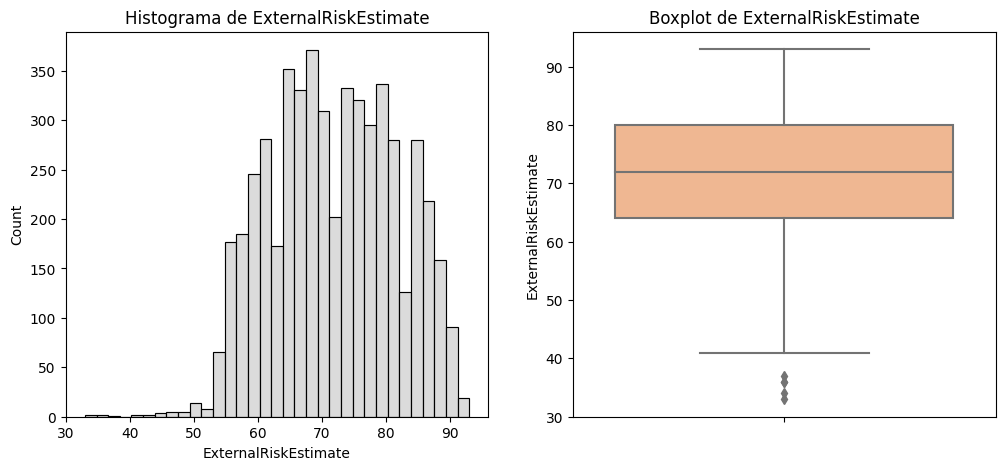

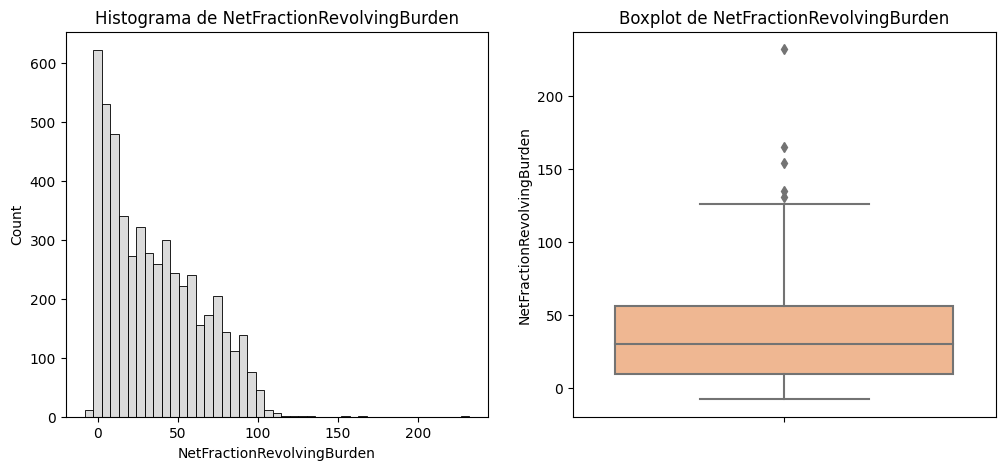

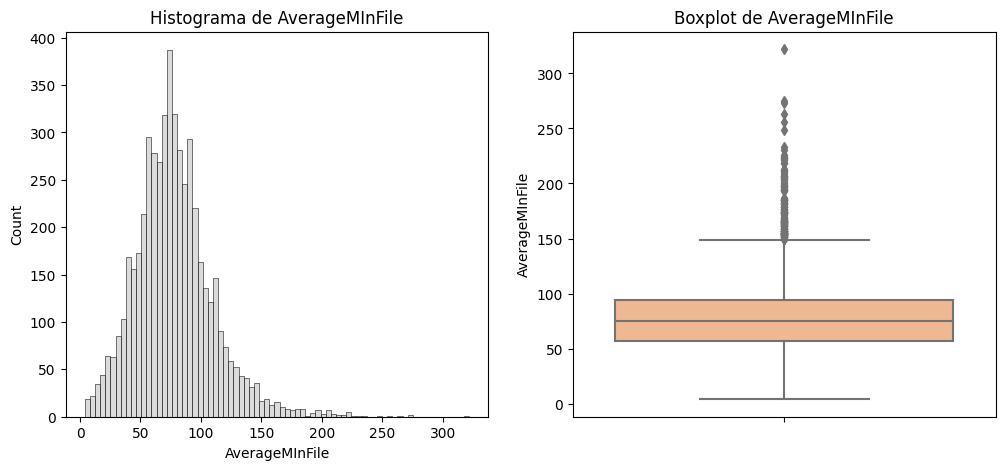

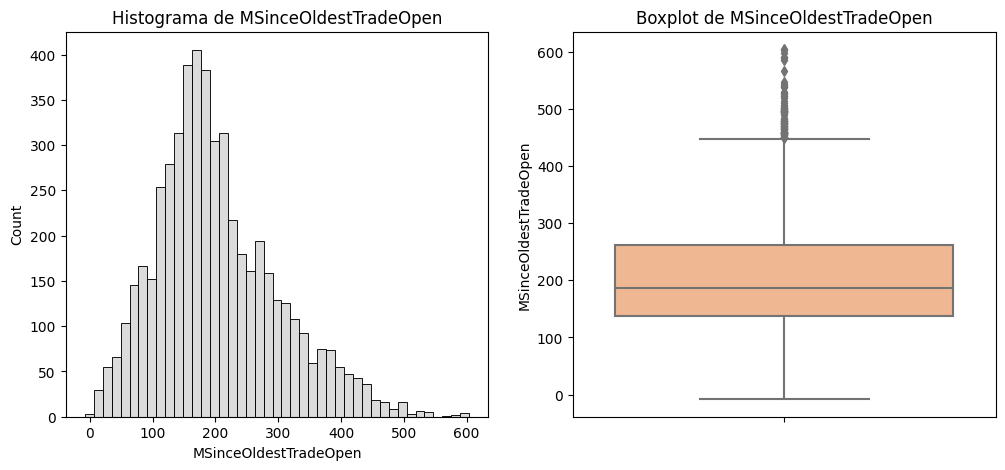

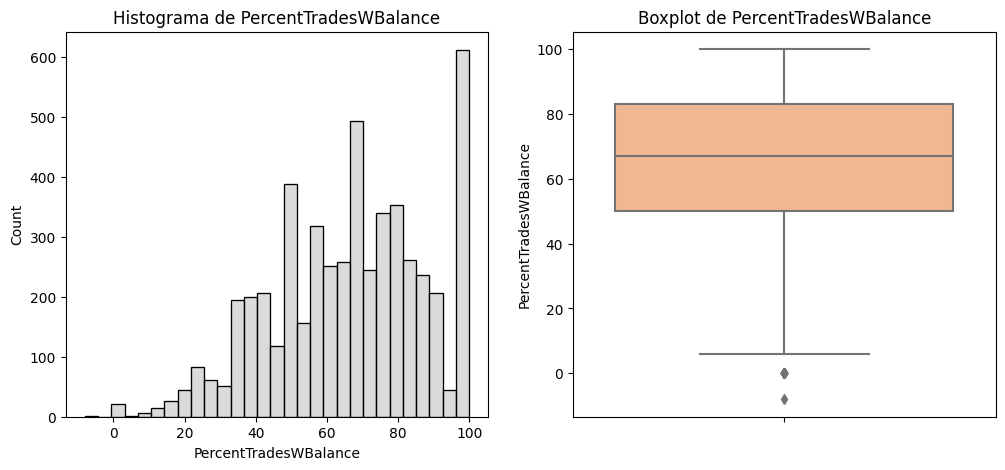

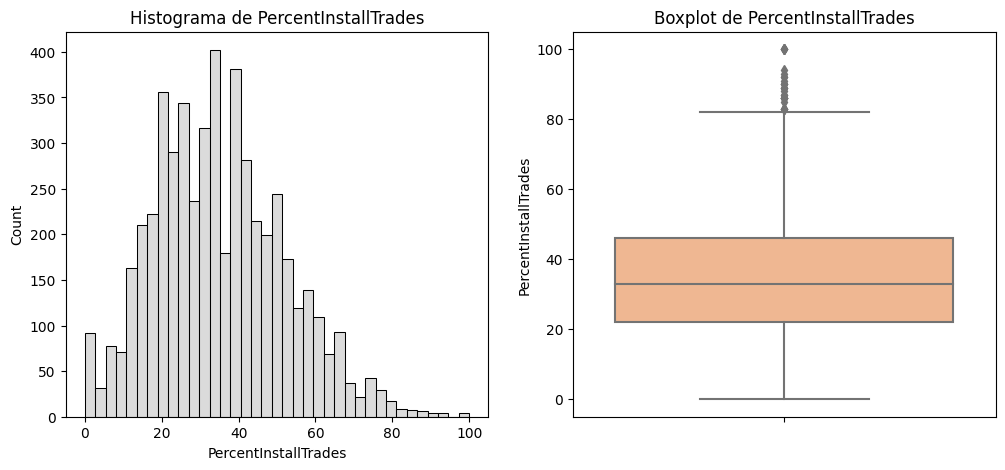

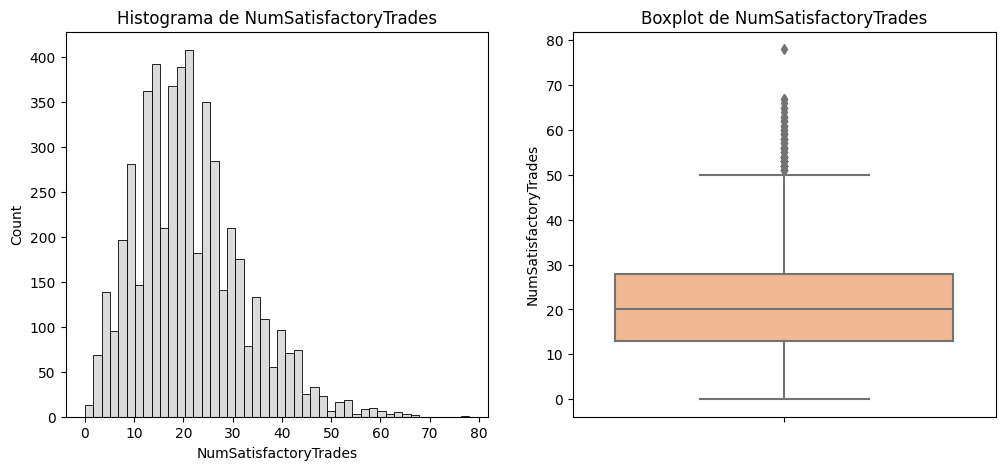

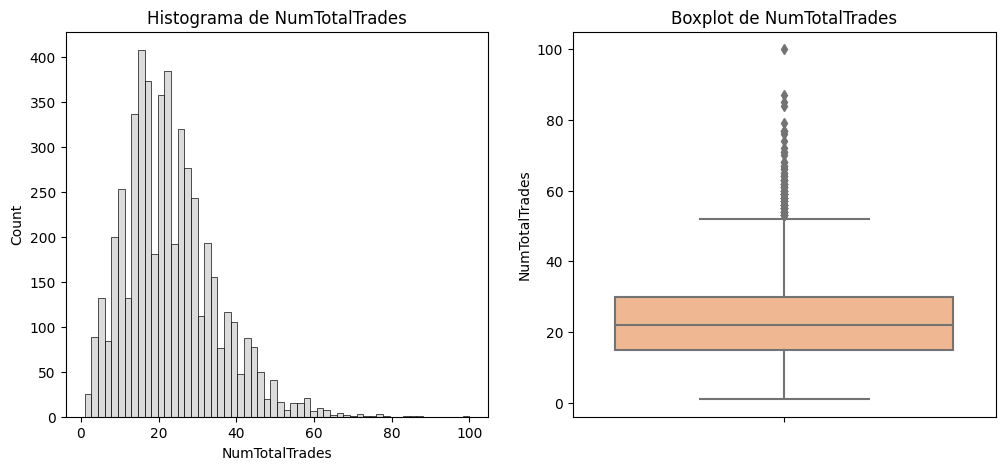

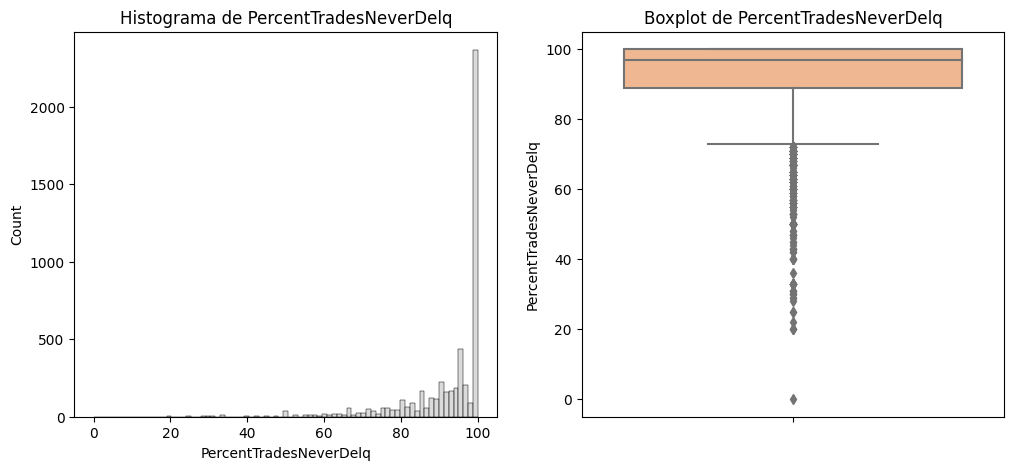

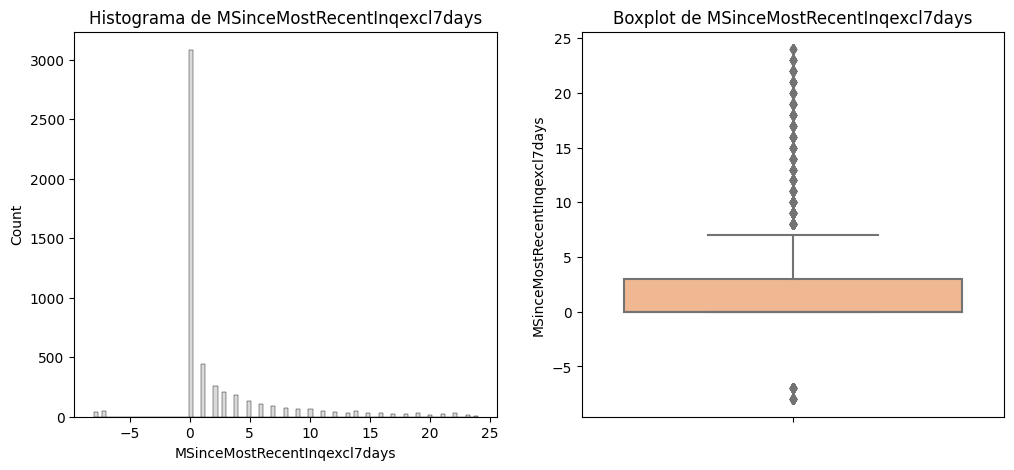

In [257]:
for var in inputs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Histograma
    sns.histplot(df[var], ax=axes[0], color=sns.color_palette('pastel')[7])
    axes[0].set_title(f'Histograma de {var}')

    # Boxplot
    sns.boxplot(y=df[var], ax=axes[1], color=sns.color_palette('pastel')[1])
    axes[1].set_title(f'Boxplot de {var}')

    plt.show()

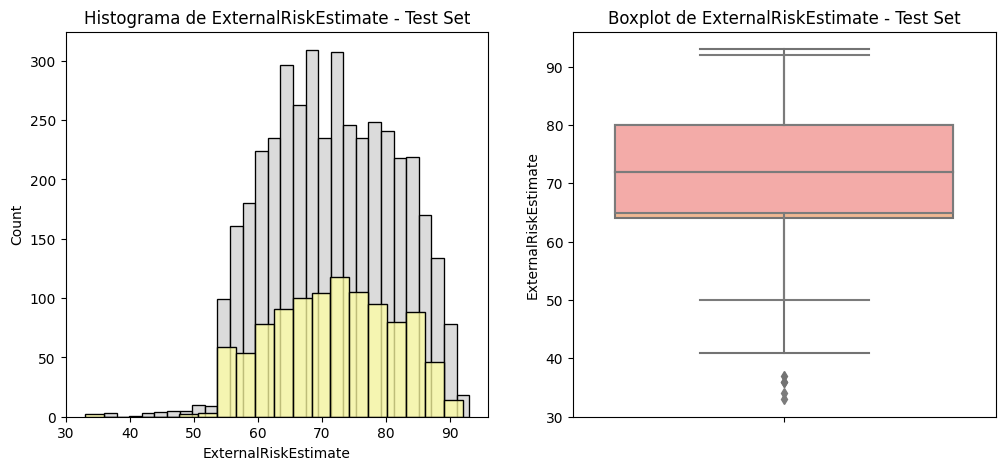

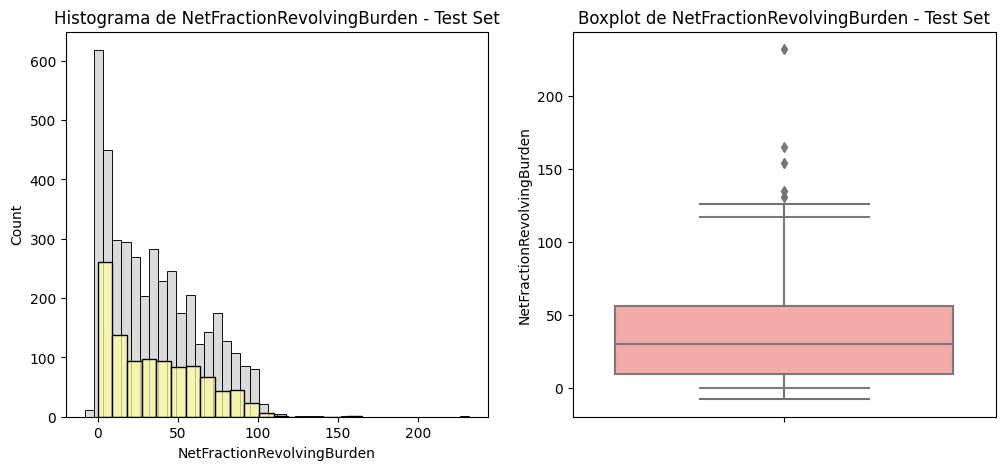

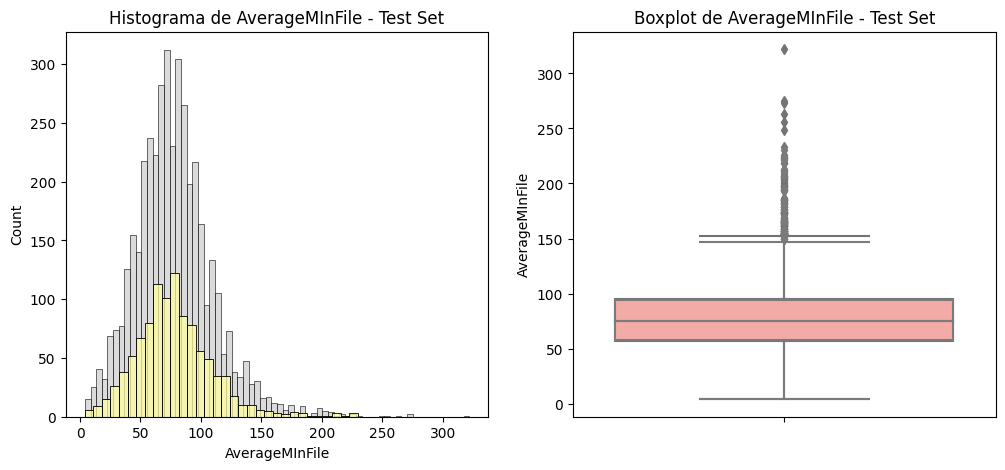

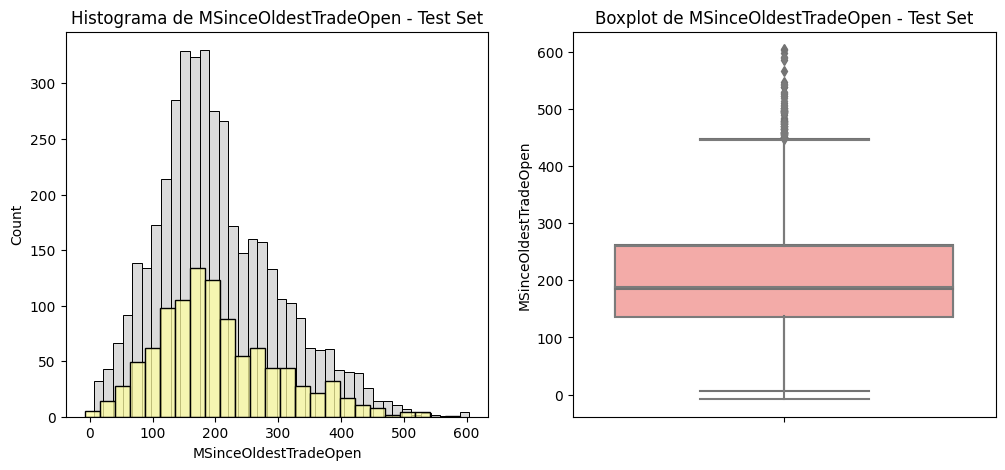

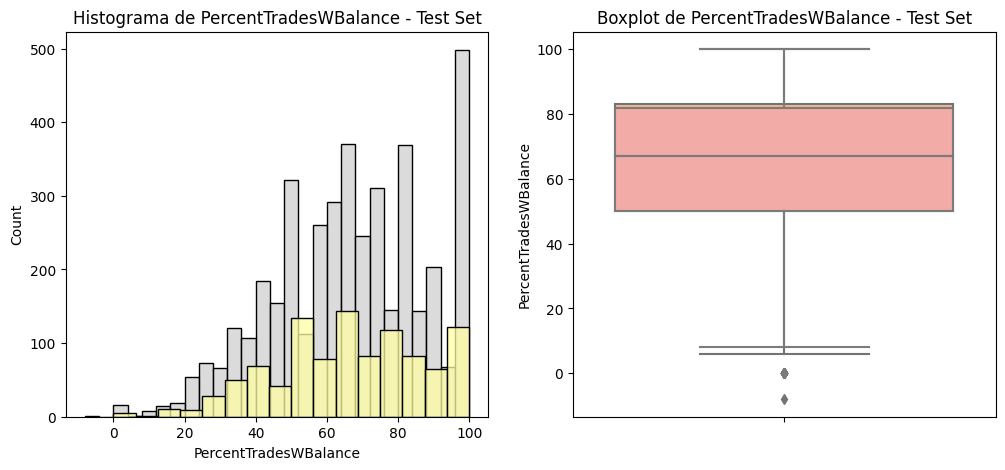

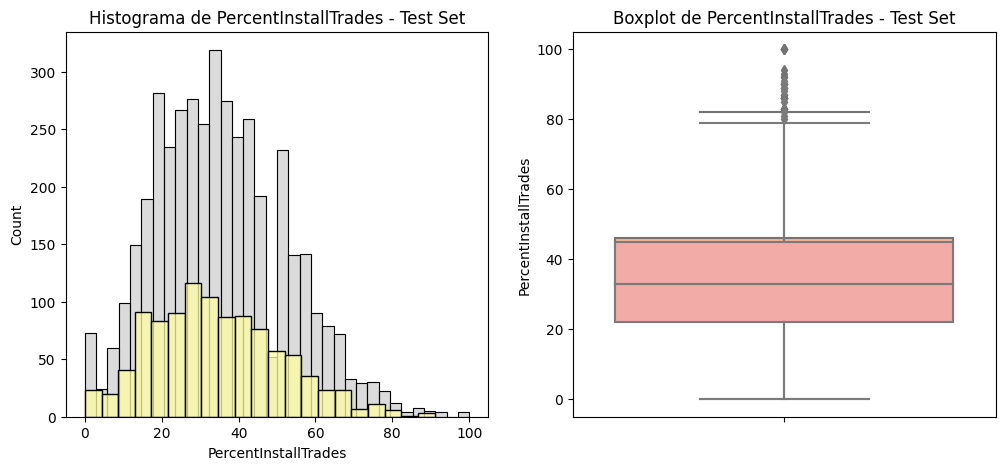

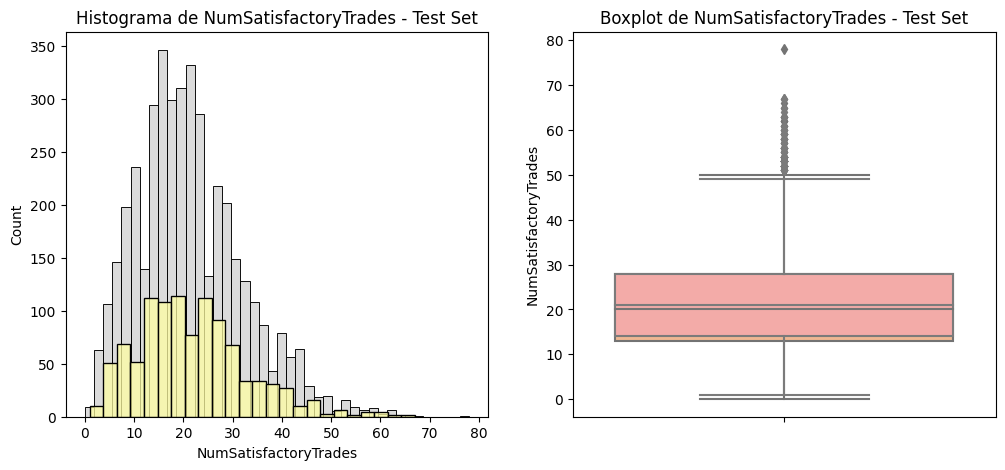

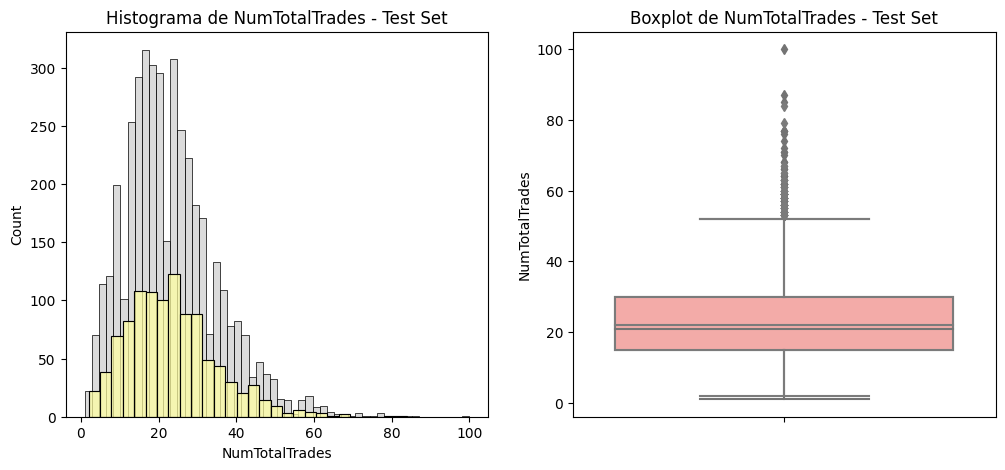

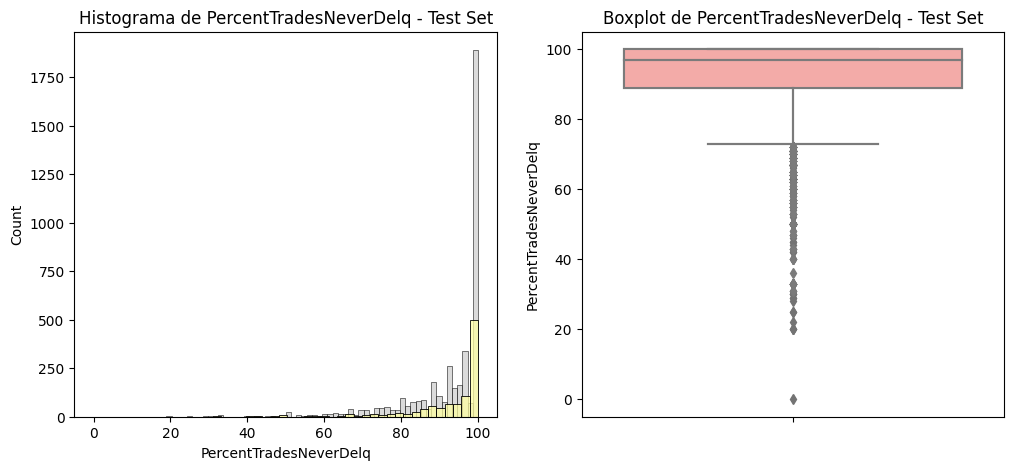

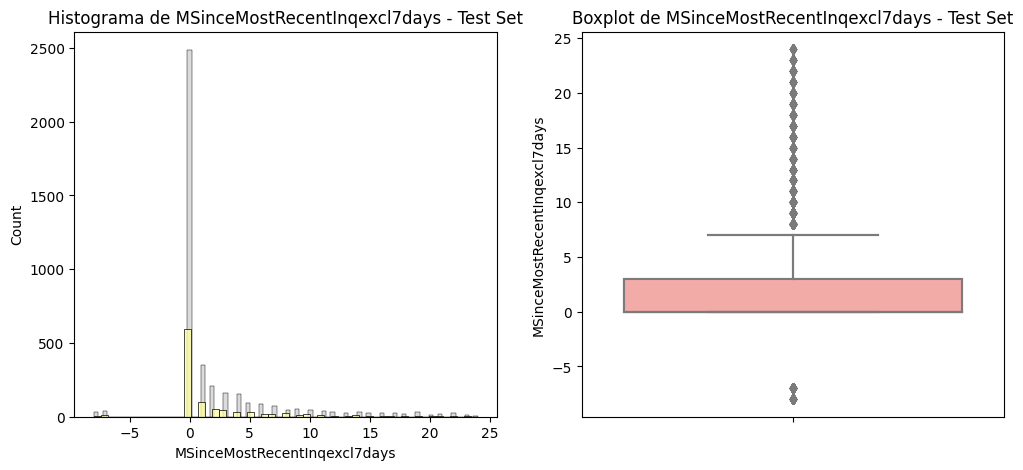

In [258]:

for var in inputs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Histograma para el conjunto de train
    sns.histplot(X_train[var], ax=axes[0], color=sns.color_palette('pastel')[7])
    axes[0].set_title(f'Histograma de {var} - Training Set')

    # Boxplot para el conjunto de train
    sns.boxplot(y=X_train[var], ax=axes[1], color=sns.color_palette('pastel')[1])
    axes[1].set_title(f'Boxplot de {var} - Training Set')
    
    # Histograma para el conjunto de test
    sns.histplot(X_test[var], ax=axes[0], color=sns.color_palette('pastel')[8])
    axes[0].set_title(f'Histograma de {var} - Test Set')

    # Boxplot para el conjunto de test
    sns.boxplot(y=X_test[var], ax=axes[1], color=sns.color_palette('pastel')[3])
    axes[1].set_title(f'Boxplot de {var} - Test Set')

    plt.show()


En estas gráficas observamos varias cosas:

    1. A pesar de que el tamaño del conjunto de datos de test es menor, sigue exactamente la misma distribución que los datos del train.

    2. En cuanto a las distribuciones, observamos que no todas las variables tienen la misma distribución, ya que hay varias normales, lognormales y exponenciales.
    
    3. Todas las variables tienen un gran número de datos atipicos, vamos a realizar ahora una estandarización de los datos del train, después, estandarizaremos los datos del test con la media y varianza obtenida en el test y evaluaremos si las distribuciones poseen menos atípicos.

In [259]:
# Estandarización de los datos del train y el test con la media y varianza del train
for variable in X_train:
    mean = X_train[f"{variable}"].mean()
    var = X_train[f"{variable}"].var()
    std = X_train[f"{variable}"].std()
    standarization_var = lambda value: (value - mean) / std
    X_train[f"{variable}"] = X_train[f"{variable}"].apply(standarization_var)
    X_test[f"{variable}"] = X_test[f"{variable}"].apply(standarization_var)

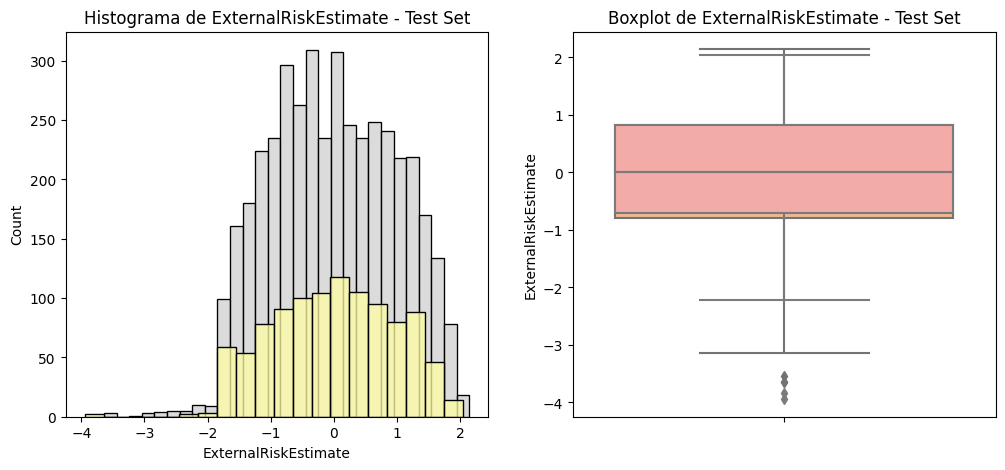

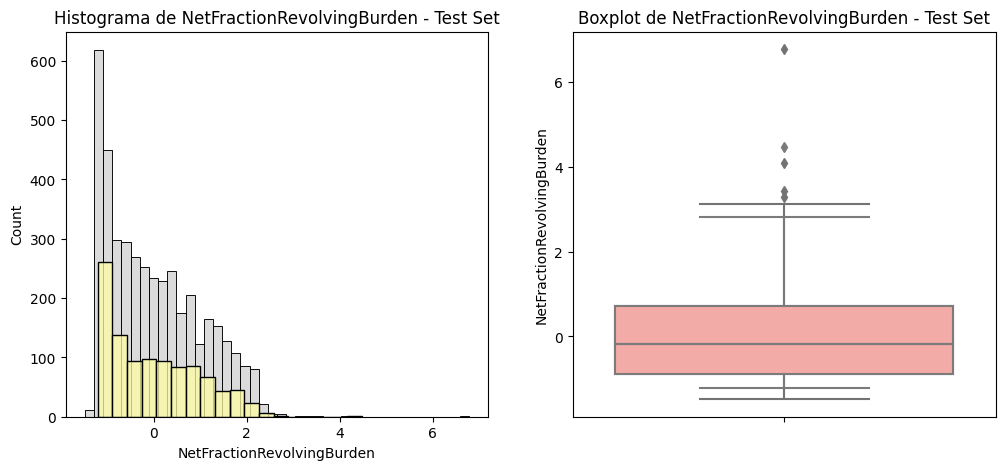

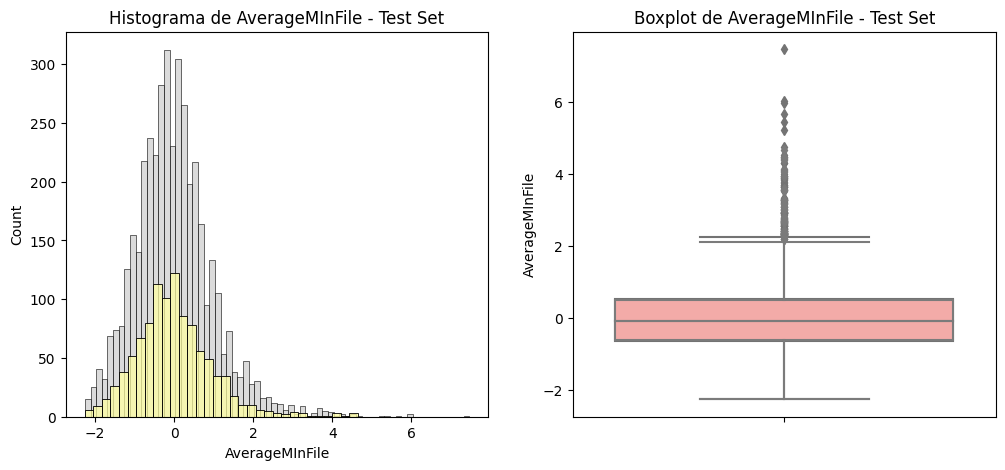

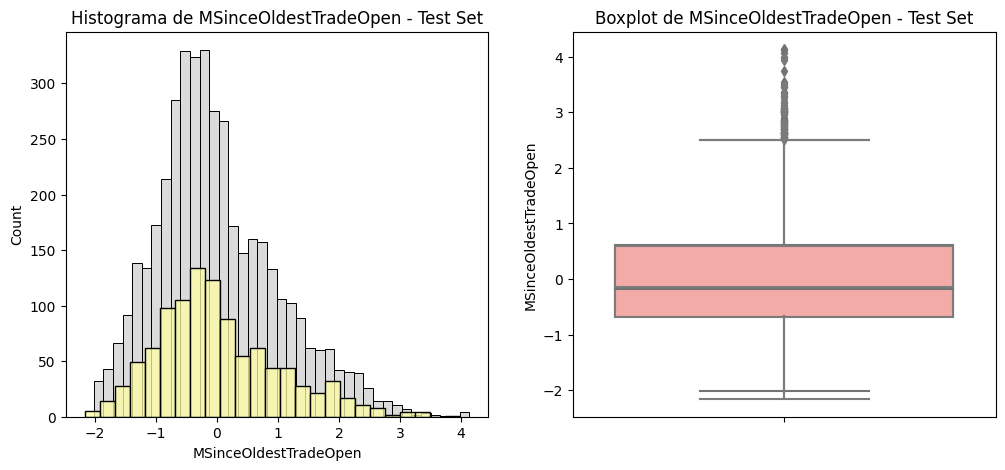

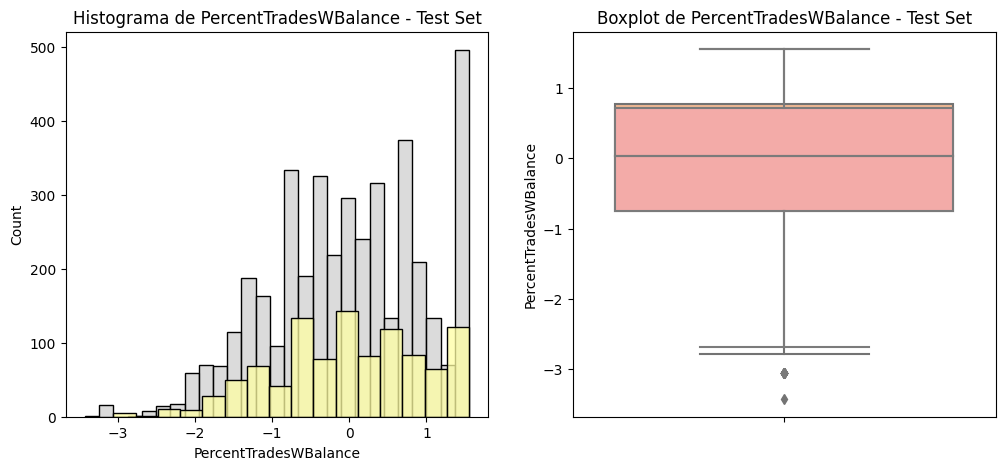

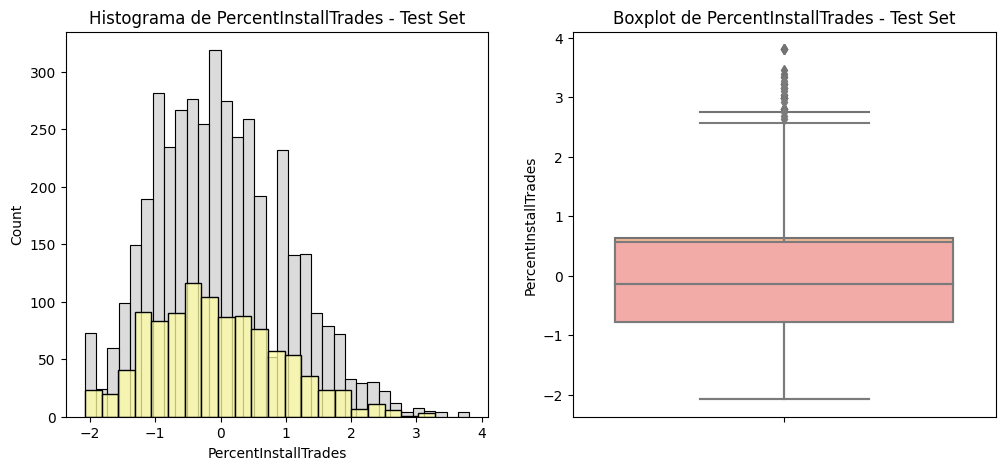

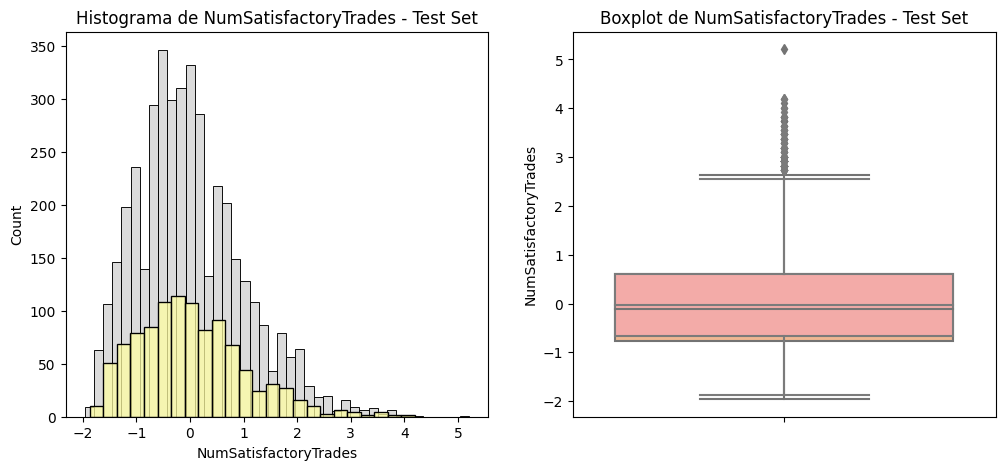

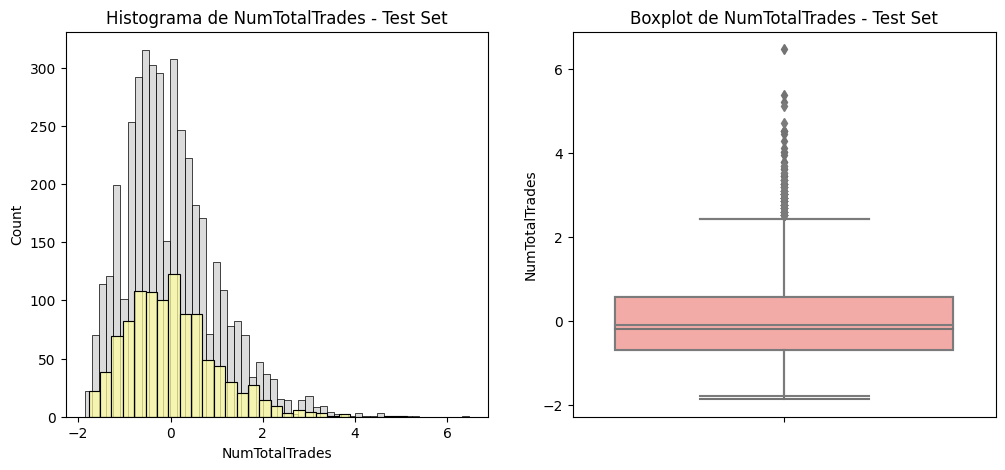

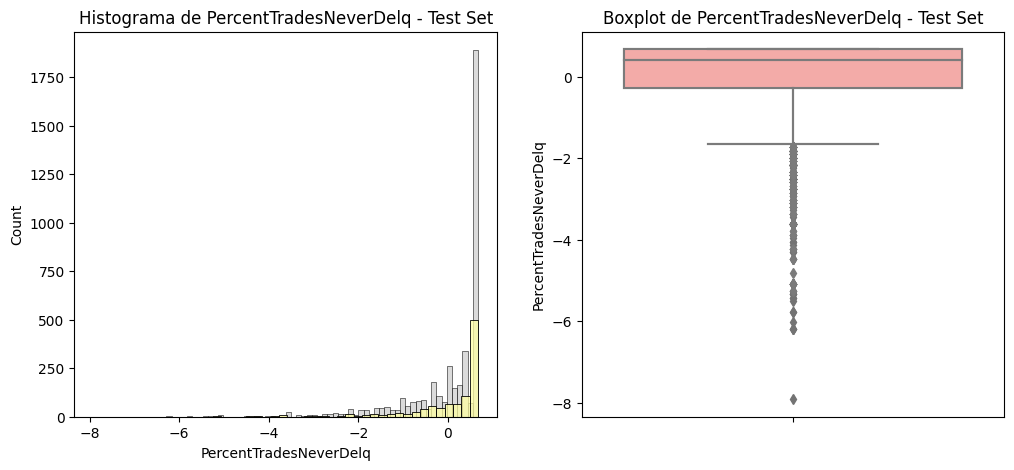

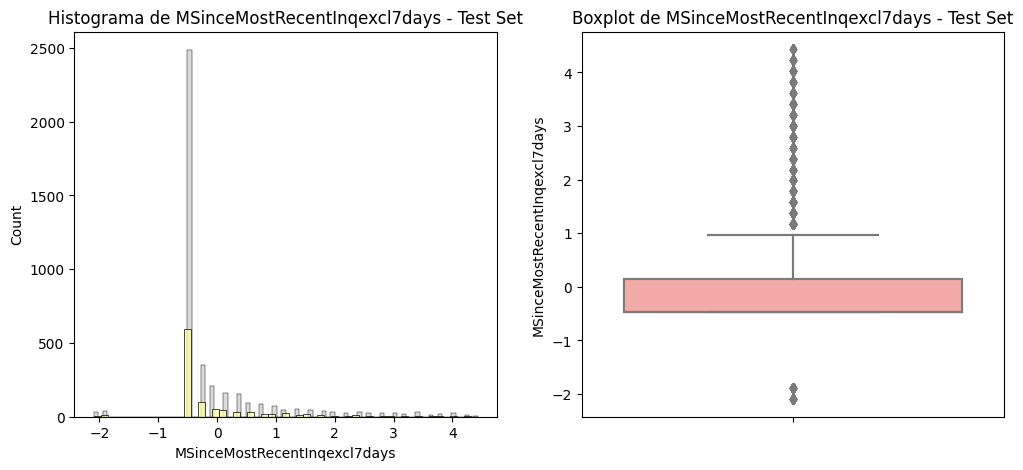

In [260]:
for var in inputs:
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    # Histograma para el conjunto de train
    sns.histplot(X_train[var], ax=axes[0], color=sns.color_palette('pastel')[7])
    axes[0].set_title(f'Histograma de {var} - Training Set')

    # Boxplot para el conjunto de train
    sns.boxplot(y=X_train[var], ax=axes[1], color=sns.color_palette('pastel')[1])
    axes[1].set_title(f'Boxplot de {var} - Training Set')
    
    # Histograma para el conjunto de test
    sns.histplot(X_test[var], ax=axes[0], color=sns.color_palette('pastel')[8])
    axes[0].set_title(f'Histograma de {var} - Test Set')

    # Boxplot para el conjunto de test
    sns.boxplot(y=X_test[var], ax=axes[1], color=sns.color_palette('pastel')[3])
    axes[1].set_title(f'Boxplot de {var} - Test Set')

    plt.show()


Observando que tras la estandarización no han cambiado de manera radical los datos, y sigue habiendo casi la misma cantidad de datos atipicos, estudiamos los datos de estas distribuciones para concluir lo que está ocurriendo.

In [261]:
print(X_train.describe())

       ExternalRiskEstimate  NetFractionRevolvingBurden  AverageMInFile  \
count          4.156000e+03                4.156000e+03    4.156000e+03   
mean          -1.829357e-16               -6.496782e-17   -1.393389e-16   
std            1.000000e+00                1.000000e+00    1.000000e+00   
min           -3.639247e+00               -1.480978e+00   -2.261933e+00   
25%           -7.985828e-01               -8.958812e-01   -6.408087e-01   
50%            1.303550e-02               -1.731143e-01   -9.023827e-02   
75%            8.246538e-01                7.217400e-01    5.215067e-01   
max            2.143534e+00                6.779215e+00    7.464812e+00   

       MSinceOldestTradeOpen  PercentTradesWBalance  PercentInstallTrades  \
count           4.156000e+03           4.156000e+03          4.156000e+03   
mean            5.171780e-17           1.436131e-16          9.232268e-17   
std             1.000000e+00           1.000000e+00          1.000000e+00   
min            -

Debido a que la mayoria de las variables se distribuyen con una normal, la estandarización de los datos no aporta demasiado ni elimina los datos atípicos de la distribución debido a que este tipo de distribuciónes son propensas a la acumulación de datos atípicos en sus colas (los extremos de la distribución).

Por otro lado, hay otras variables con una distribución más exponencial o incluso logarítmica, en estas, la presencia de datos atípicos también es común y no debemos suponer por ello que sean datos inoportunos, sino que podemos entender que dado que no han desaparecido, son datos relevantes sobre los que deberemos realizar un estudio más profundo cuando entremos el dataset.

## Paso 4: Estudio de la correlación entre variables

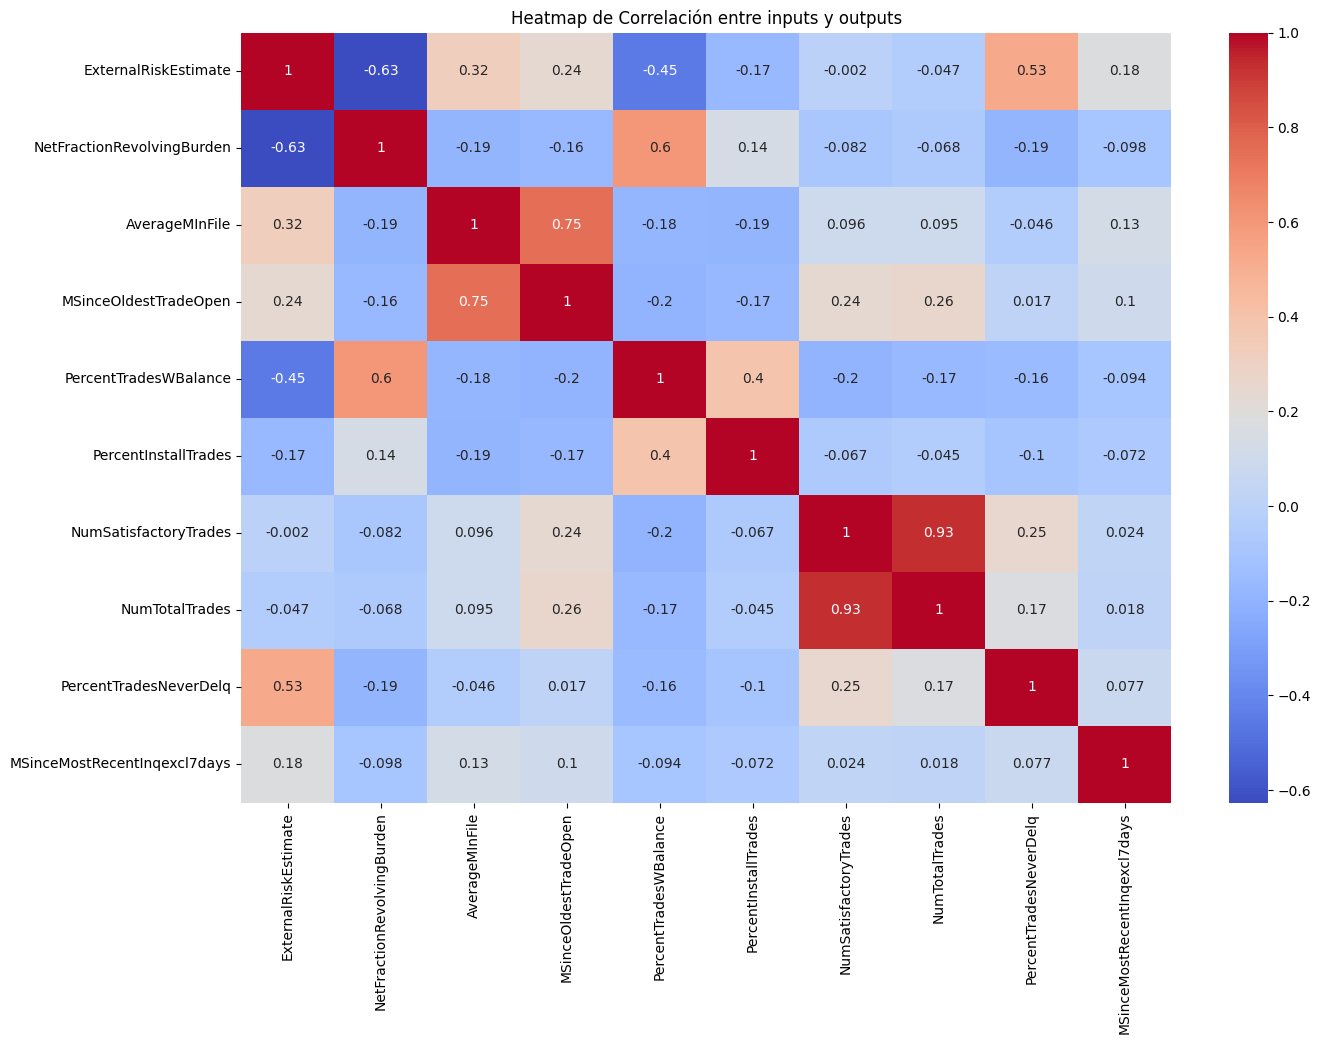

In [262]:
correlation_matrix = X_train.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Heatmap de Correlación entre inputs y outputs")
plt.show()

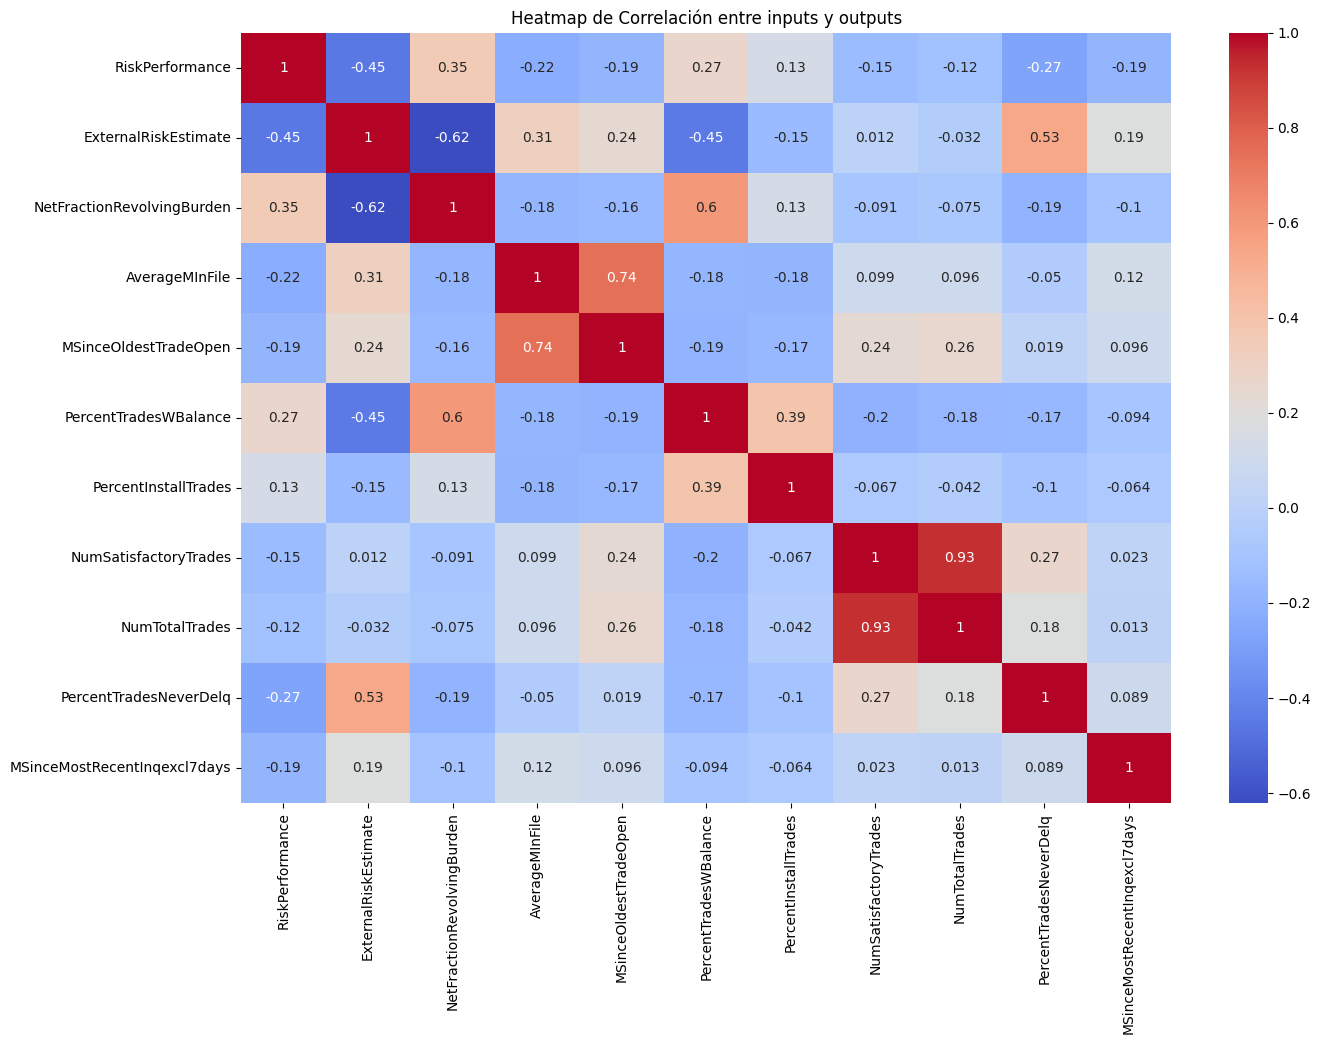

In [314]:
correlation_matrix = df.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Heatmap de Correlación entre inputs y outputs")
plt.show()

Las variables que presentan la mayor correlación entre si son a las que más importancia debemos prestar, ya que son las que escogeremos en algunos modelos más adelante como las características importantes, y si aplicamos algún tipo de regularización veremos que son las menos penalizadas, es decir, son las que más nos informan sobre los datos.

Estas son (de mayor a menor covarianza) (cogemos aquellas con una cor >= 0.6, ya que menos no es muy relevante): 

    - NumTotalTrades con NumSatisfactoryTrades (0.93)

    - MSinceOldestTradeOpen con AverageMinFile (0.74)

# PARTE 2: Classification

In [263]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestClassifier # aunque los árboles no son muy robustos para datos atípicos es un buen ejemplo para mostrarlo y ver cuánto overfitting producen estos modelos con datasets donde los datos atípicos también son relevantes.
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import metrics

In [179]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

KNeighborsClassifier()

Optimal value of k: 71 with a score of 0.7297822364158104


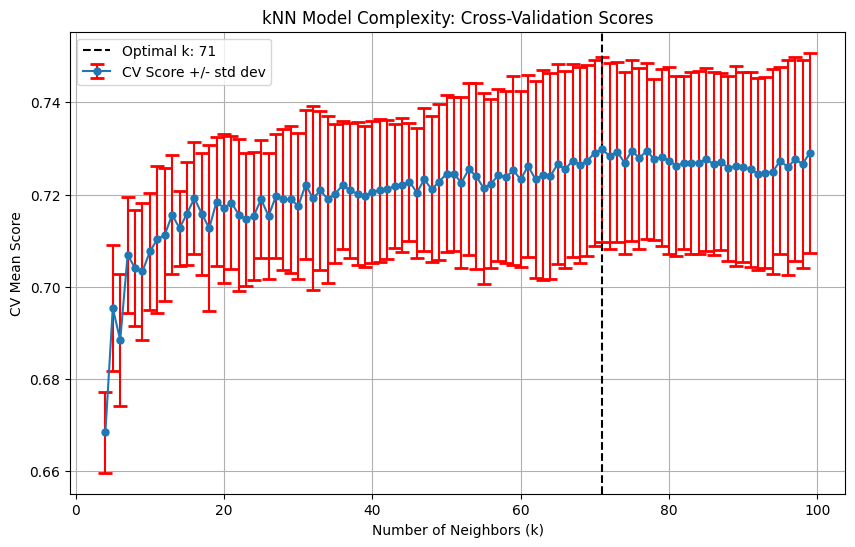

In [180]:
k_values = range(4,100)
mean_scores, std_scores, optimal_value_KNN_train, highest_score = cv_model(knn_model, X_train, y_train, k_values, "n_neighbors")

print(f"Optimal value of k: {optimal_value_KNN_train} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value_KNN_train, linestyle='--', color='k', label=f'Optimal k: {optimal_value_KNN_train}')

plt.title('kNN Model Complexity: Cross-Validation Scores')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


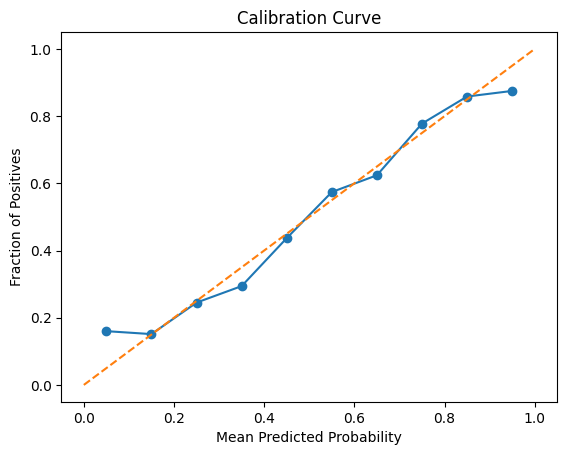

{'Confusion Matrix': [378, 146, 139, 376],
 'Accuracy': 0.7256977863330125,
 'Precision': 0.7203065134099617,
 'Recall': 0.7300970873786408,
 'Specificity': 0.7213740458015268,
 'F1 Score': 0.7251687560270008}

In [335]:
knn_model = KNeighborsClassifier(n_neighbors=optimal_value_KNN_train)
knn_model.fit(X_train, y_train)
y_test_prob_knn = knn_model.predict_proba(X_test)
classification_report(y_test, y_test_prob_knn[:,1], 1)

In [319]:
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

LogisticRegression()

Optimal value of C: 4 with a score of 0.7283402179950013


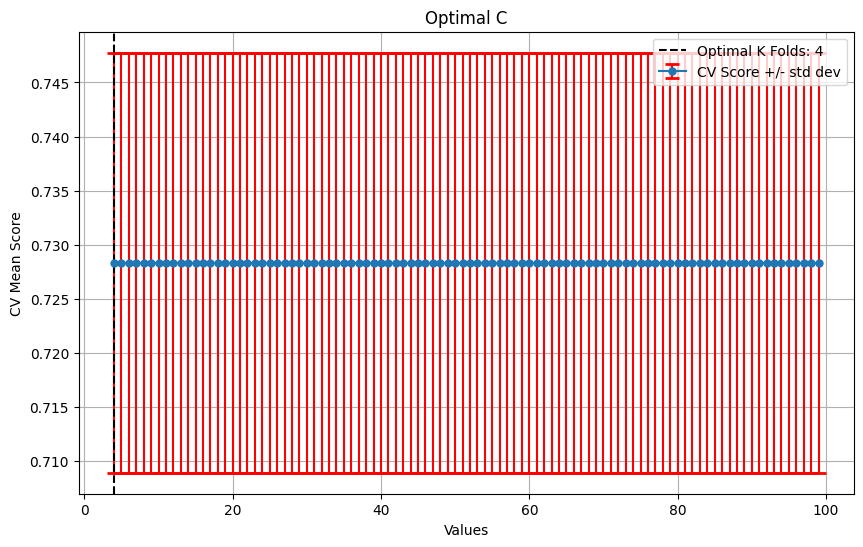

In [183]:
values = range(4,100)
mean_scores, std_scores, optimal_logregC_train, highest_score  = cv_model(logreg_model, X_train, y_train, values, "C")

print(f"Optimal value of C: {optimal_logregC_train} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(k_values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_logregC_train, linestyle='--', color='k', label=f'Optimal K Folds: {optimal_logregC_train}')

plt.title('Optimal C')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


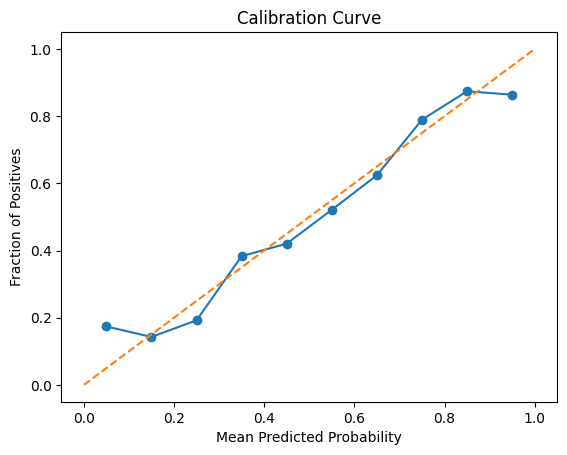

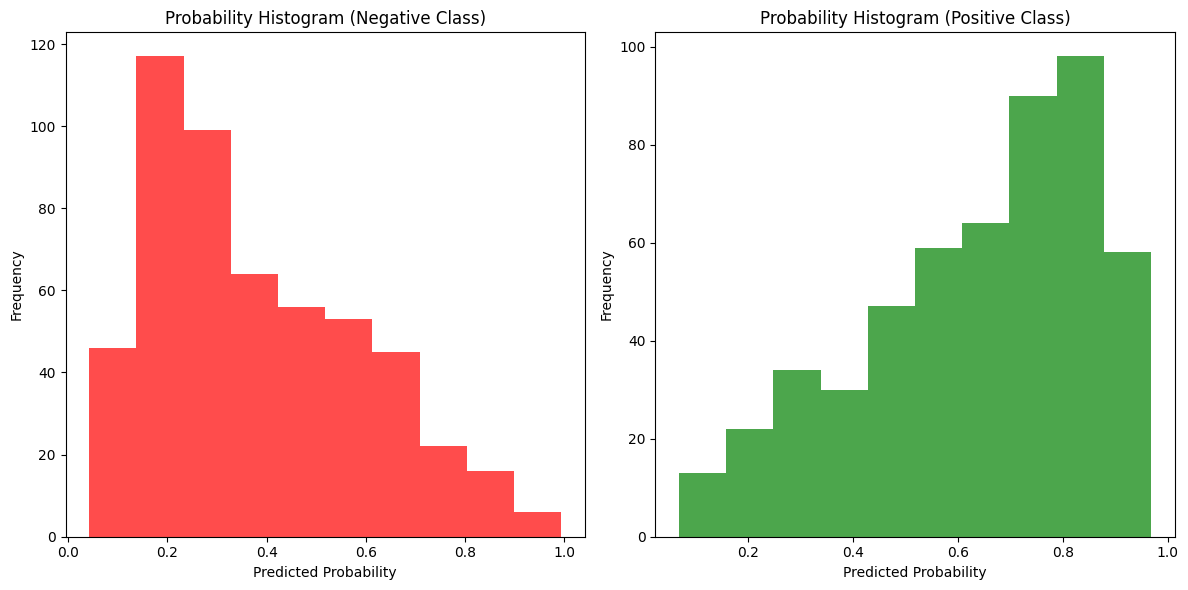

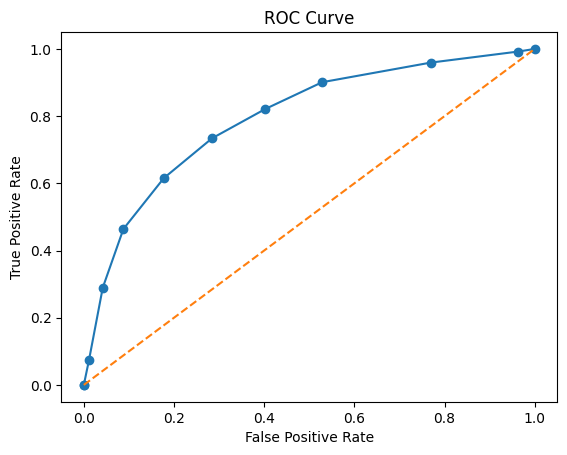

{'Confusion Matrix': [375, 149, 137, 378],
 'Accuracy': 0.7247353224254091,
 'Precision': 0.7172675521821632,
 'Recall': 0.7339805825242719,
 'Specificity': 0.7156488549618321,
 'F1 Score': 0.7255278310940501}

In [320]:
logreg_model = LogisticRegression(C=optimal_logregC_train)
logreg_model.fit(X_train, y_train)
y_test_prob_logreg = logreg_model.predict_proba(X_test)
classification_report(y_test, y_test_prob_logreg[:,1], 1)

The optimum value of C based on accuracy is: 1e-08


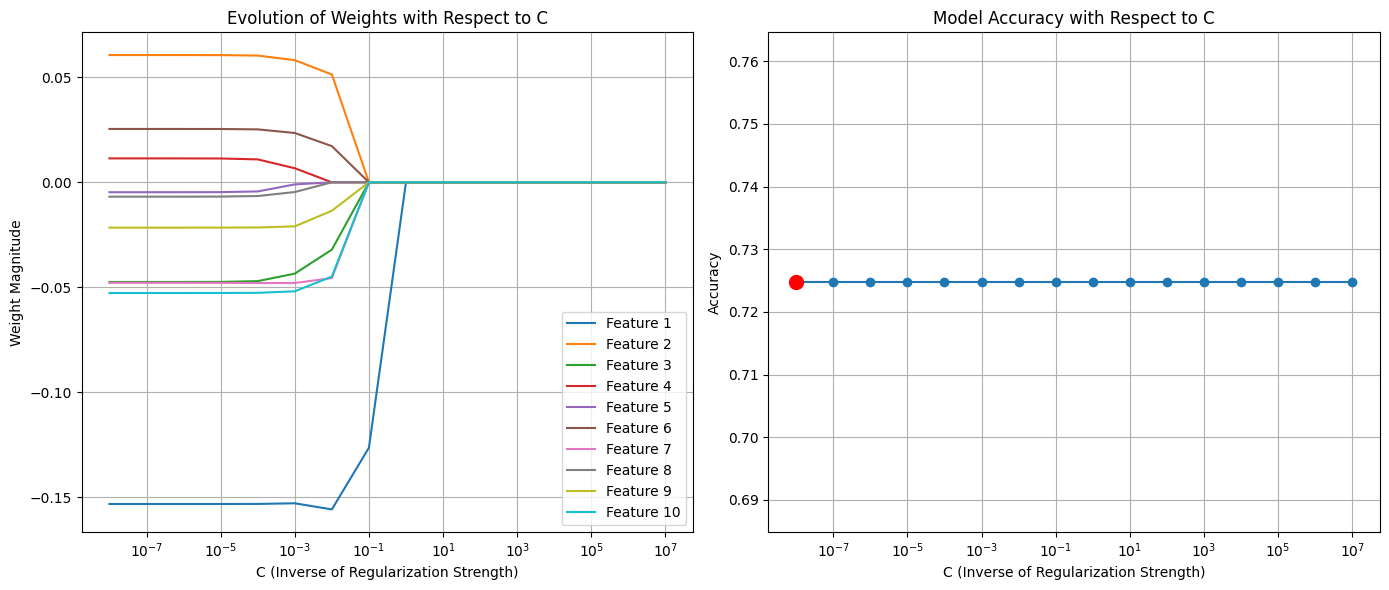

In [321]:
lasso_model = Lasso(alpha=0.01) 
lasso_model.fit(X_train, y_train)

pow_min = -8
pow_max = 7

C_values = [10**i for i in range(pow_min, pow_max+1)]  # Vector of \lambda (regularization parameters)
weights_evolution = []  # To store the final weights for each C
accuracies = []

for C in C_values:
    model = Lasso(alpha=C)  # Create a new Lasso model with the current C value
    model.fit(X_train, y_train)
    weights_evolution.append(model.coef_)
    
    # Predict and calculate accuracy
    y_pred = logreg_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

max_accuracy = max(accuracies)
idx = accuracies.index(max_accuracy)
optimum_C = C_values[idx]

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()


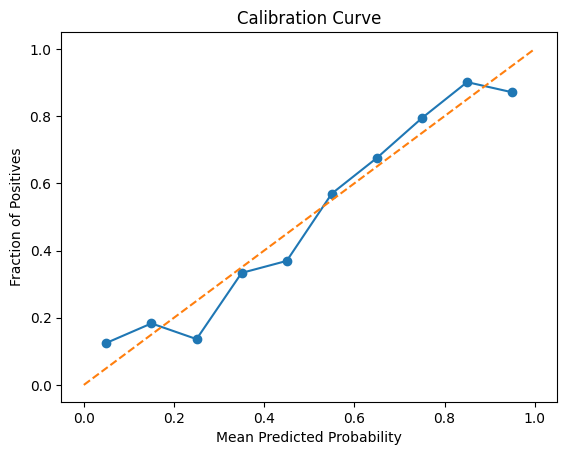

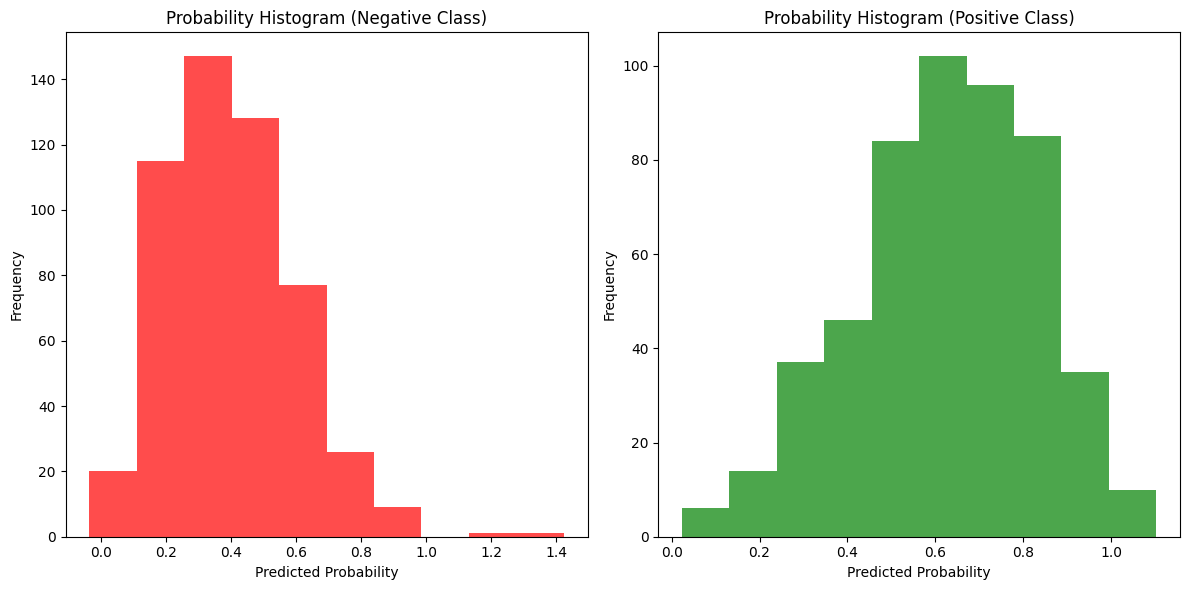

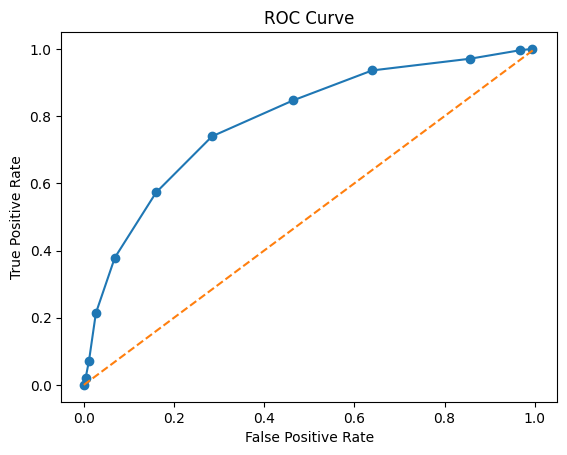

{'Confusion Matrix': [375, 149, 134, 381],
 'Accuracy': 0.7276227141482194,
 'Precision': 0.7188679245283018,
 'Recall': 0.7398058252427184,
 'Specificity': 0.7156488549618321,
 'F1 Score': 0.7291866028708134}

In [322]:
y_test_prob_lasso = lasso_model.predict(X_test)
classification_report(y_test, y_test_prob_lasso, 1)

The optimum value of C based on accuracy is: 1e-08


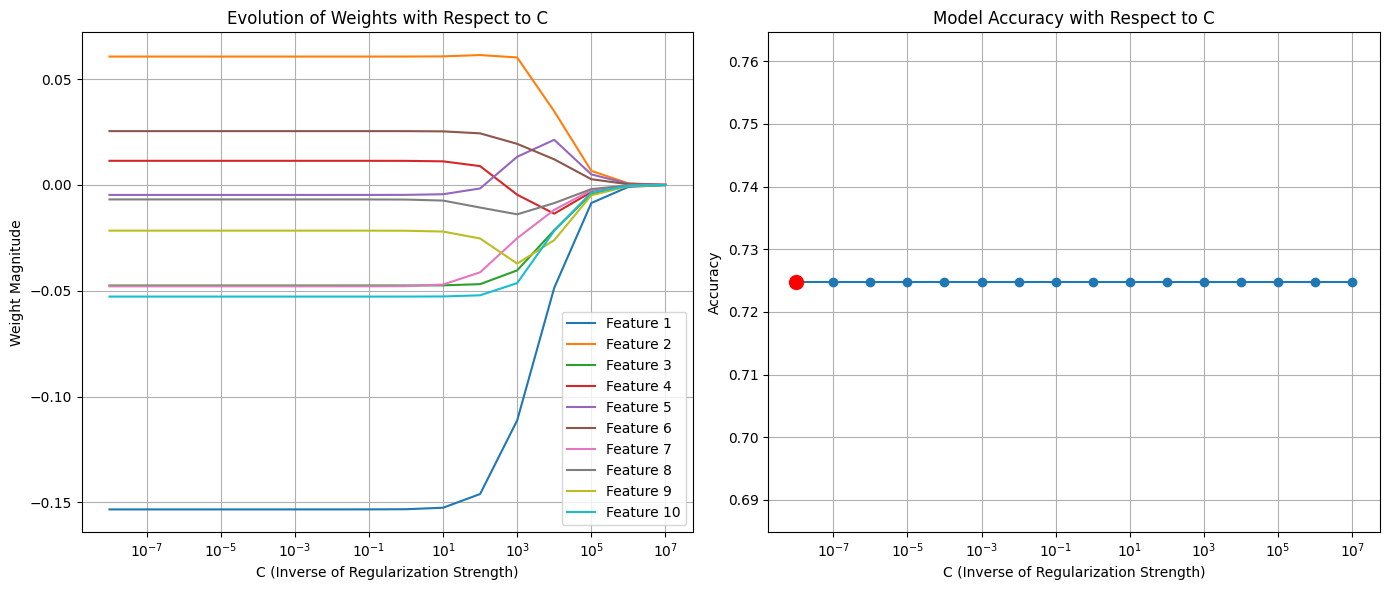

In [323]:
ridge_model = Ridge(alpha=0.01)  # Puedes ajustar el valor de alpha según sea necesario
ridge_model.fit(X_train, y_train)
# predictions = ridge_model.predict(X_test)

pow_min = -8
pow_max = 7

C_values = [10**i for i in range(pow_min, pow_max+1)]  # Vector of \lambda (regularization parameters)
weights_evolution = []  # To store the final weights for each C
accuracies = []

for C in C_values:
    model = Ridge(alpha=C)  # Create a new Lasso model with the current C value
    model.fit(X_train, y_train)
    weights_evolution.append(model.coef_)
    
    # Predict and calculate accuracy
    y_pred = logreg_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

max_accuracy = max(accuracies)
idx = accuracies.index(max_accuracy)
optimum_C = C_values[idx]

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()



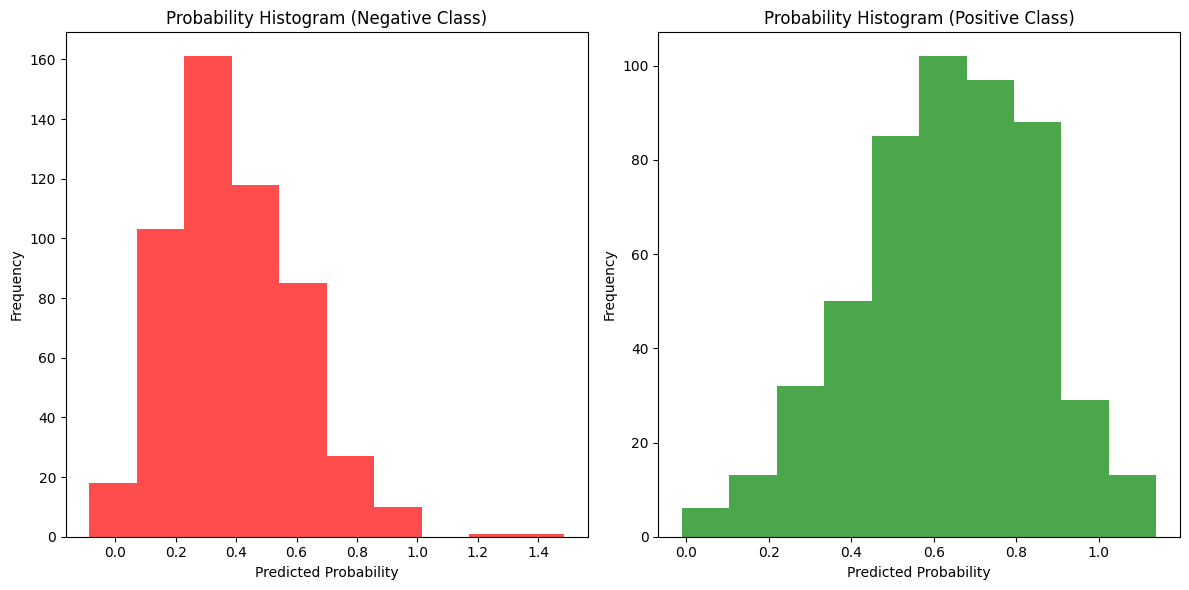

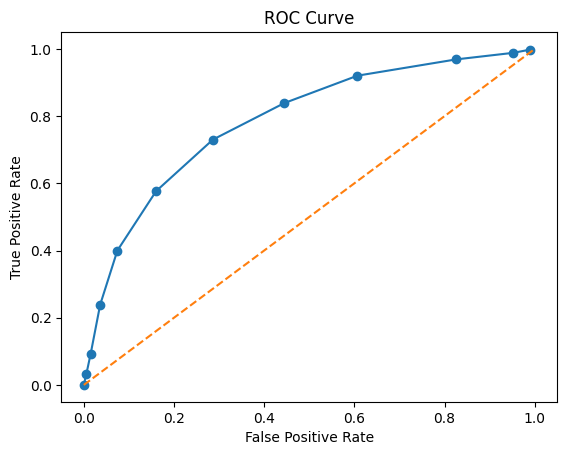

{'Confusion Matrix': [374, 150, 139, 376],
 'Accuracy': 0.7218479307025987,
 'Precision': 0.714828897338403,
 'Recall': 0.7300970873786408,
 'Specificity': 0.7137404580152672,
 'F1 Score': 0.7223823246878001}

In [324]:
y_test_prob_ridge = ridge_model.predict(X_test)
classification_report(y_test, y_test_prob_ridge, 1)

The optimum value of C based on accuracy is: 1e-08


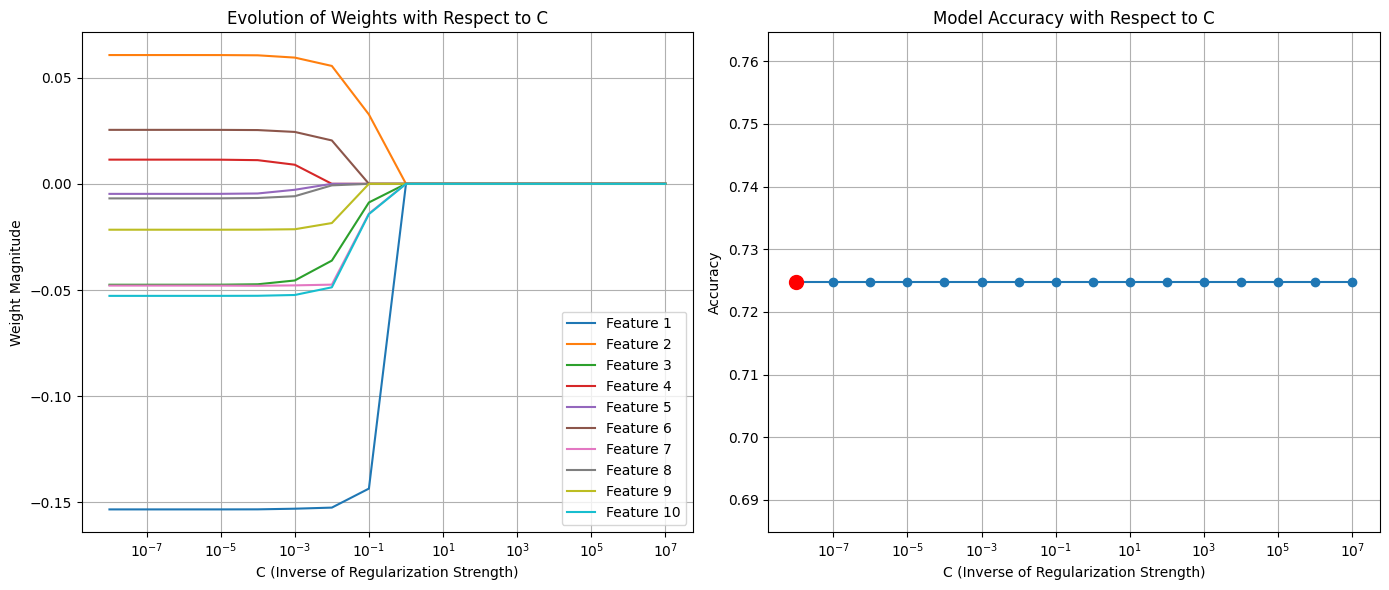

In [325]:
elasticnet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)  # Puedes ajustar el valor de alpha y l1_ratio según sea necesario
elasticnet_model.fit(X_train, y_train)

pow_min = -8
pow_max = 7

C_values = [10**i for i in range(pow_min, pow_max+1)]  # Vector of \lambda (regularization parameters)
weights_evolution = []  # To store the final weights for each C
accuracies = []

for C in C_values:
    model = ElasticNet(alpha=C)  # Create a new Lasso model with the current C value
    model.fit(X_train, y_train)
    weights_evolution.append(model.coef_)
    
    # Predict and calculate accuracy
    y_pred = logreg_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

# Plotting the evolution of weights
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for feature_index in range(len(weights_evolution[0])):
    weight_trajectory = [weights[feature_index] for weights in weights_evolution]
    plt.plot(C_values, weight_trajectory, label=f'Feature {feature_index + 1}')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Weight Magnitude')
plt.title('Evolution of Weights with Respect to C')
plt.legend(loc='best')
plt.grid(True)

max_accuracy = max(accuracies)
idx = accuracies.index(max_accuracy)
optimum_C = C_values[idx]

print(f"The optimum value of C based on accuracy is: {optimum_C}")

# Plotting accuracy as a function of C
plt.subplot(1, 2, 2)
plt.plot(C_values, accuracies, marker='o', linestyle='-')
plt.plot(optimum_C, max_accuracy, 'ro', markersize=10, label='Optimum C')
plt.xscale('log')
plt.xlabel('C (Inverse of Regularization Strength)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy with Respect to C')
plt.grid(True)

plt.tight_layout()
plt.show()



In [326]:
elasticnet_model = ElasticNet(alpha=1e-08, l1_ratio=0.5)  # Puedes ajustar el valor de alpha y l1_ratio según sea necesario
elasticnet_model.fit(X_train, y_train)

ElasticNet(alpha=1e-08)

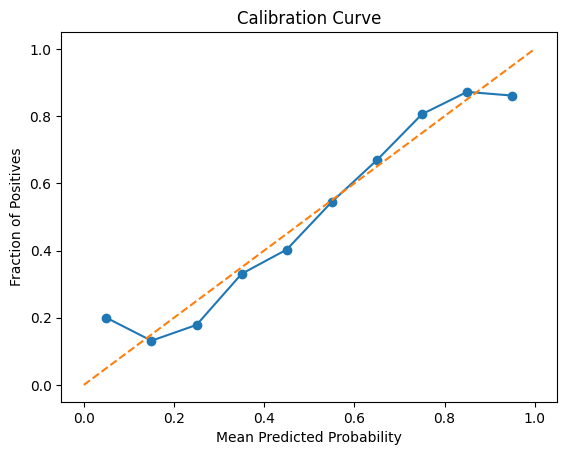

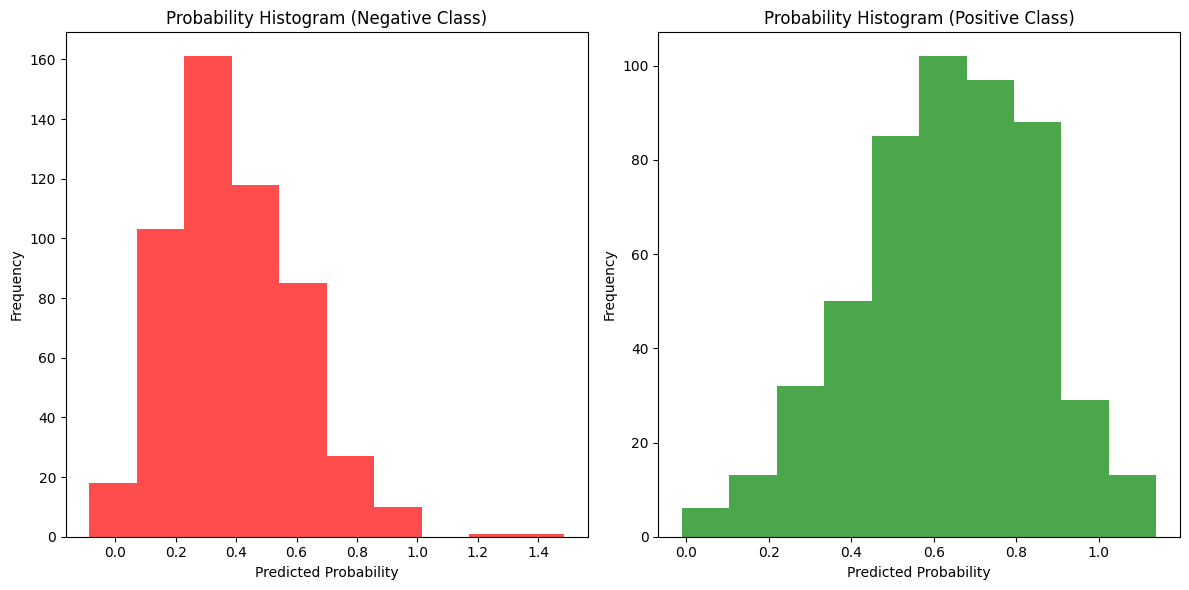

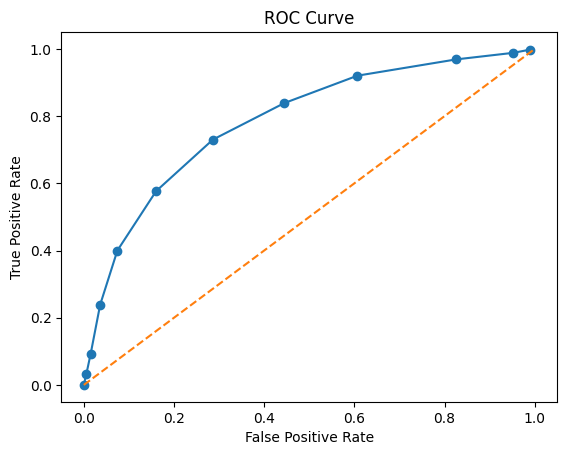

{'Confusion Matrix': [374, 150, 139, 376],
 'Accuracy': 0.7218479307025987,
 'Precision': 0.714828897338403,
 'Recall': 0.7300970873786408,
 'Specificity': 0.7137404580152672,
 'F1 Score': 0.7223823246878001}

In [327]:
y_test_prob_elasticnet = elasticnet_model.predict(X_test)
classification_report(y_test, y_test_prob_elasticnet, 1)

In [192]:
randomforest_model = RandomForestClassifier()
randomforest_model.fit(X_train, y_train)

RandomForestClassifier()

Optimal n estimators: 74 with a score of 0.7242507868184764


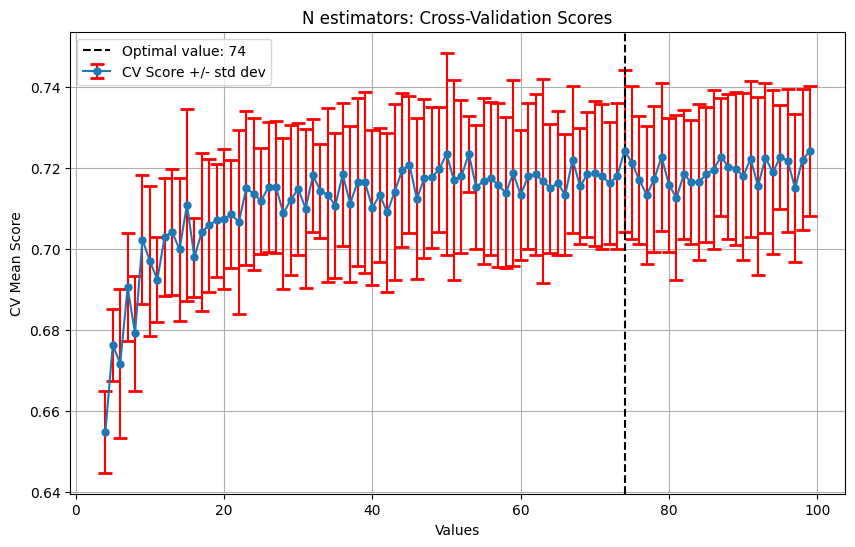

In [193]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(randomforest_model, X_train, y_train, values, "n_estimators")

print(f"Optimal n estimators: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('N estimators: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal depth: 8 with a score of 0.7281015690086088


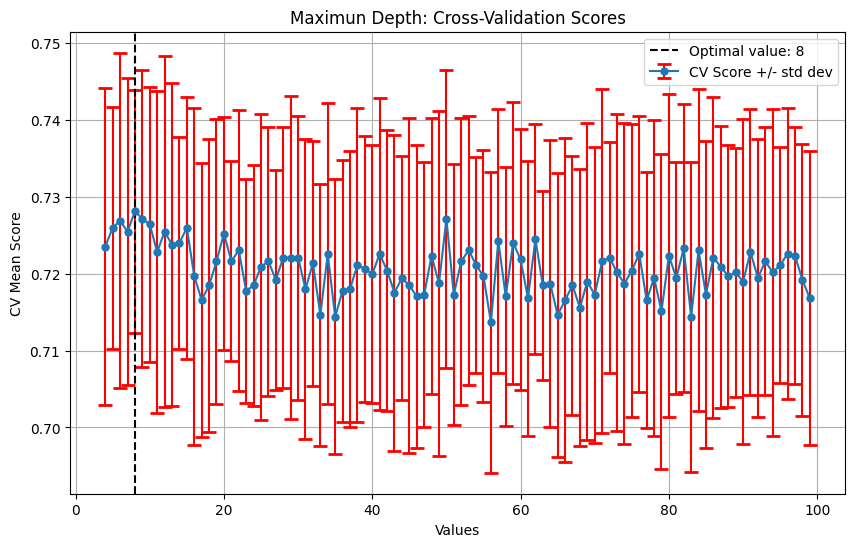

In [194]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(randomforest_model, X_train, y_train, values, "max_depth")

print(f"Optimal depth: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('Maximun Depth: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal min samples split: 39 with a score of 0.7290645538276405


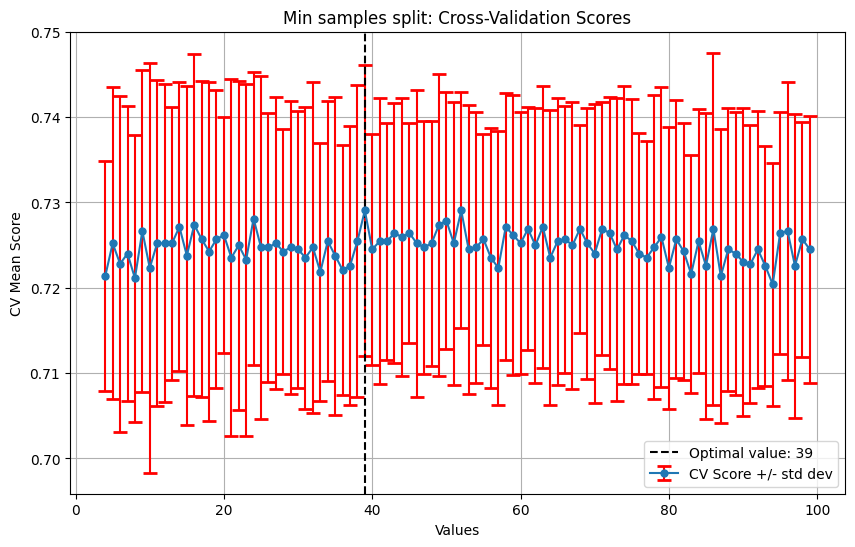

In [195]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(randomforest_model, X_train, y_train, values, "min_samples_split")

print(f"Optimal min samples split: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('Min samples split: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal min samples leaf: 45 with a score of 0.7290622396556512


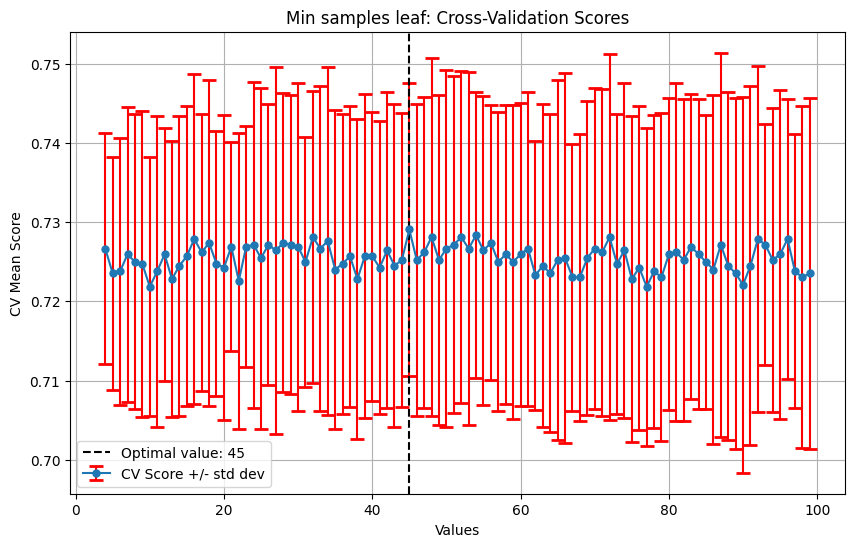

In [196]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(randomforest_model, X_train, y_train, values, "min_samples_leaf")

print(f"Optimal min samples leaf: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('Min samples leaf: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


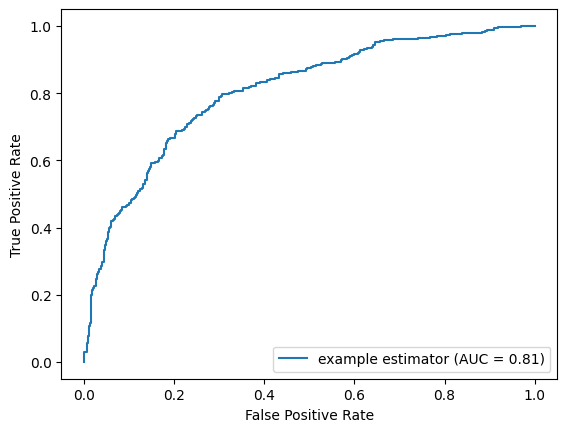

In [197]:
randomforest_model = RandomForestClassifier(n_estimators=92,max_depth=7,min_samples_split=56,min_samples_leaf=5)
randomforest_model.fit(X_train, y_train)
y_test_prob_rfc = randomforest_model.predict_log_proba(X_test)

y = np.array(y_test.astype("int"))
pred = y_test_prob_rfc[:,1] 
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

### Classification Trees

In [198]:
arbol_clasificador = DecisionTreeClassifier()
arbol_clasificador.fit(X_train, y_train)

DecisionTreeClassifier()

Optimal depth: 4 with a score of 0.7074065074516339


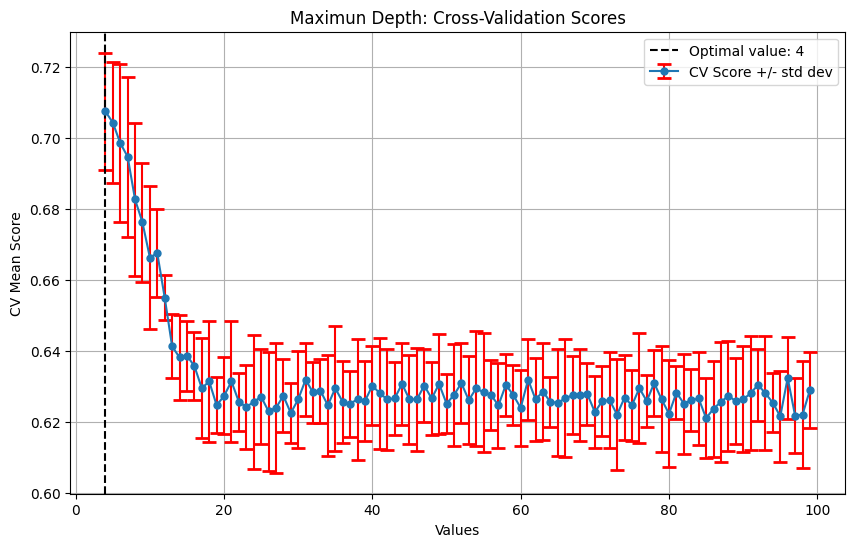

In [199]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(arbol_clasificador, X_train, y_train, values, "max_depth")

print(f"Optimal depth: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('Maximun Depth: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal min samples split: 94 with a score of 0.6927337892252152


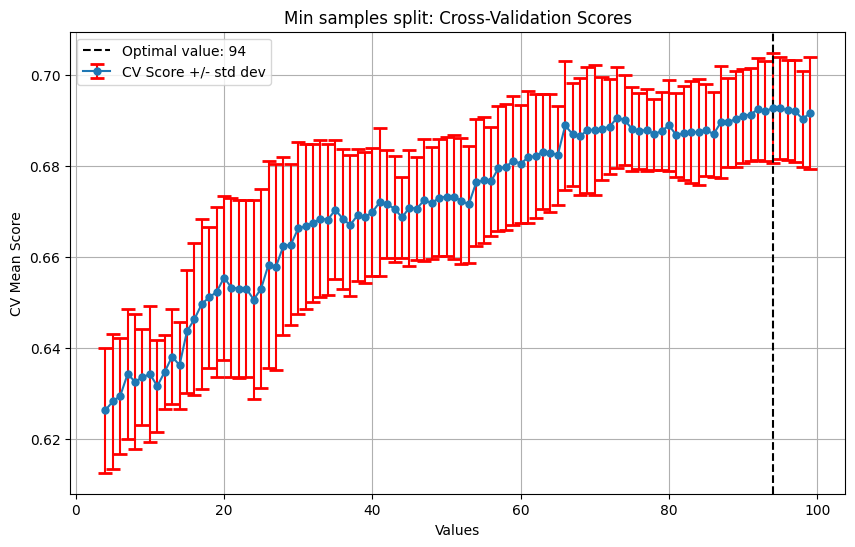

In [200]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(arbol_clasificador, X_train, y_train, values, "min_samples_split")

print(f"Optimal min samples split: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('Min samples split: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal min samples leaf: 82 with a score of 0.7141447977413682


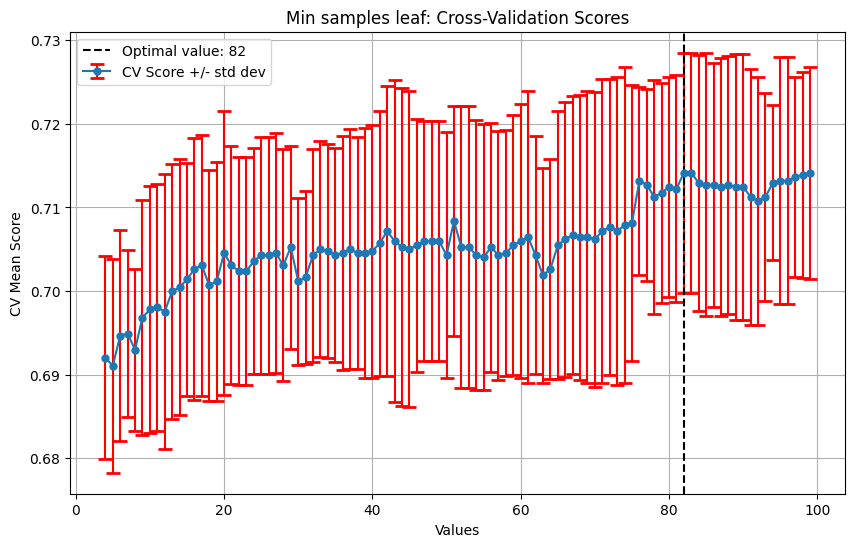

In [201]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(arbol_clasificador, X_train, y_train, values, "min_samples_leaf")

print(f"Optimal min samples leaf: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('Min samples leaf: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


In [225]:
y_test_prob_arbol_clasificador = arbol_clasificador.predict_log_proba(X_test)
y_test_prob_arbol_clasificador

array([[-1.03032638, -0.44144021],
       [-0.55004634, -0.86020127],
       [-0.14128877, -2.02676225],
       ...,
       [-0.14128877, -2.02676225],
       [-1.55091634, -0.23832518],
       [-0.14128877, -2.02676225]])

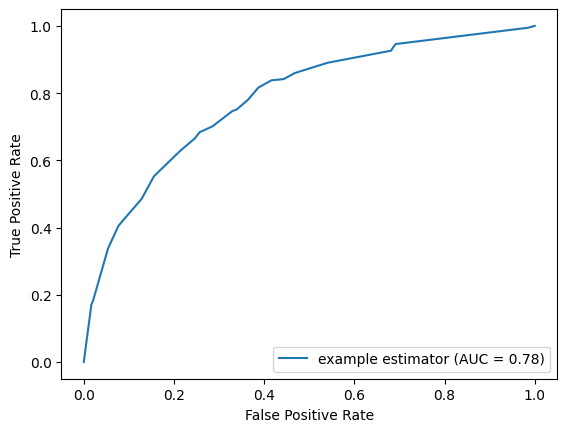

In [202]:
arbol_clasificador = DecisionTreeClassifier(max_depth=5, min_samples_split=99, min_samples_leaf=21)
arbol_clasificador.fit(X_train, y_train)
y_test_prob_arbol_clasificador = arbol_clasificador.predict_log_proba(X_test)

y = np.array(y_test.astype("int"))
pred = y_test_prob_arbol_clasificador[:,1] 
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

### Bootstrap Aggregating

In [203]:
bootstrap = BaggingClassifier()
bootstrap.fit(X_train, y_train)

BaggingClassifier()

Optimal n estimators: 87 with a score of 0.7189582754790337


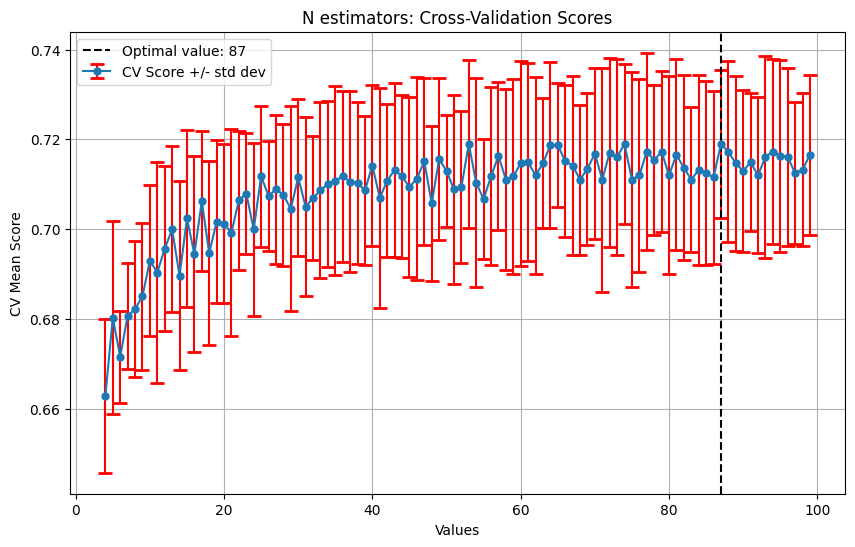

In [204]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(bootstrap, X_train, y_train, values, "n_estimators")

print(f"Optimal n estimators: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('N estimators: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal n estimators: 55 with a score of 0.7319511941127465


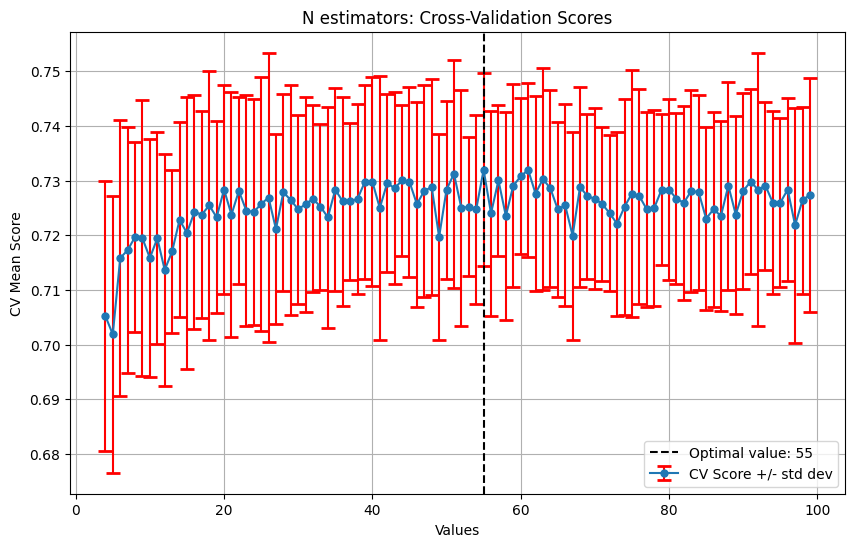

In [205]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(bootstrap, X_train, y_train, values, "max_samples")

print(f"Optimal n estimators: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('N estimators: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:1035: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:1035: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:1035: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\tree\_classes.py:1035: RuntimeWarning: divide by zero encountered in log
  return np.log(proba)
C:\Users\meryg\AppData\Local

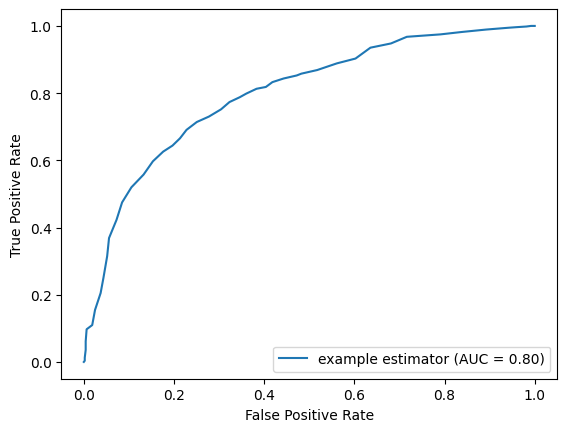

In [206]:
bootstrap = BaggingClassifier(n_estimators=53, max_samples=32)
bootstrap.fit(X_train, y_train)
y_test_prob_bootstrap = bootstrap.predict_log_proba(X_test)

y = np.array(y_test.astype("int"))
pred = y_test_prob_bootstrap[:,1] 
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

### Boosting

In [207]:
boosting = GradientBoostingClassifier()
boosting.fit(X_train, y_train)

GradientBoostingClassifier()

Optimal n estimators: 40 with a score of 0.7314692677959826


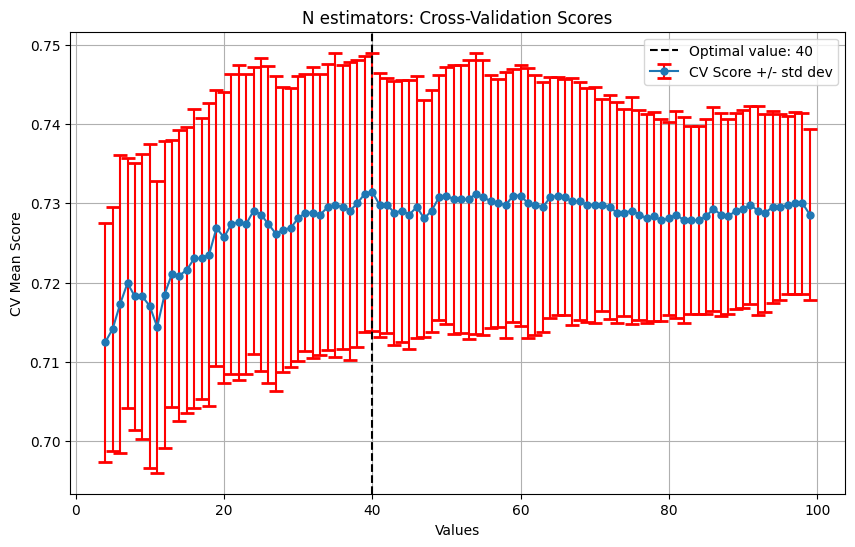

In [208]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(boosting, X_train, y_train, values, "n_estimators")

print(f"Optimal n estimators: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('N estimators: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


Optimal n estimators: 6 with a score of 0.6239458946588912


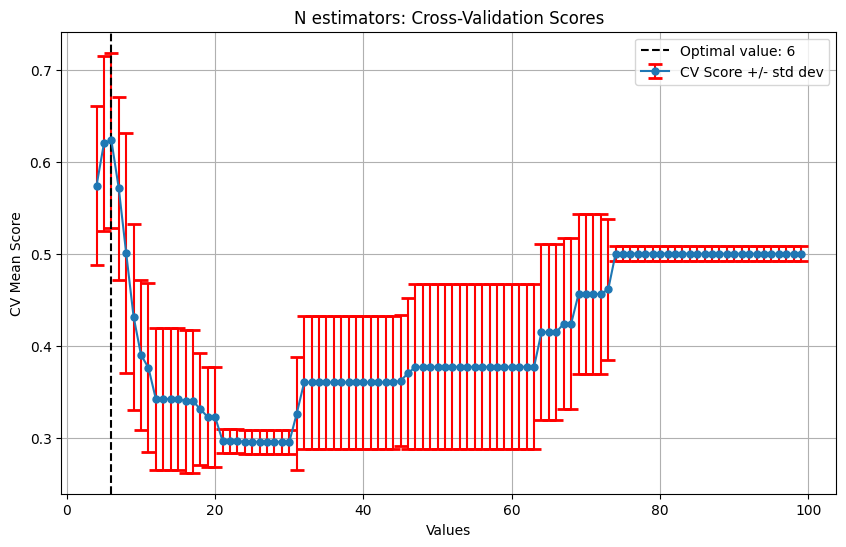

In [209]:
values = range(4,100)
mean_scores, std_scores, optimal_value, highest_score = cv_model(boosting, X_train, y_train, values, "learning_rate")

print(f"Optimal n estimators: {optimal_value} with a score of {highest_score}")

# Plotting
plt.figure(figsize=(10, 6))
plt.errorbar(values, mean_scores, yerr=std_scores, fmt='-o', ecolor='r', capsize=5, capthick=2, markersize=5, label='CV Score +/- std dev')
plt.axvline(x=optimal_value, linestyle='--', color='k', label=f'Optimal value: {optimal_value}')

plt.title('Learning_rate: Cross-Validation Scores')
plt.xlabel('Values')
plt.ylabel('CV Mean Score')
plt.legend()
plt.grid(True)
plt.show()


### SVM
Posibles parámetros a evaluar por validación cruzada:

C: Parámetro de regularización. Controla el balance entre maximizar el margen y minimizar la clasificación incorrecta. 

kernel: Tipo de kernel a utilizar (lineal, polinomial, radial, etc.). Estudiamos cuál se ajusta mejor a los datos.

gamma: Coeficiente para kernels no lineales. 

sigma: Parametro determinante de rbf

In [211]:
svm_model = SVC(cache_size=7000)
svm_model.fit(X_train, y_train)

SVC(cache_size=7000)

In [212]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1,10], 'gamma': [0.1,1,10], 'kernel': ['rbf']}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Model fit.")

# Obtener los mejores parámetros y el mejor kernel encontrados
best_params = grid_search.best_params_
print(best_params)
best_kernel = best_params['kernel']
print("El mejor kernel encontrado es:", best_kernel)

Model fit.
{'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}
El mejor kernel encontrado es: rbf


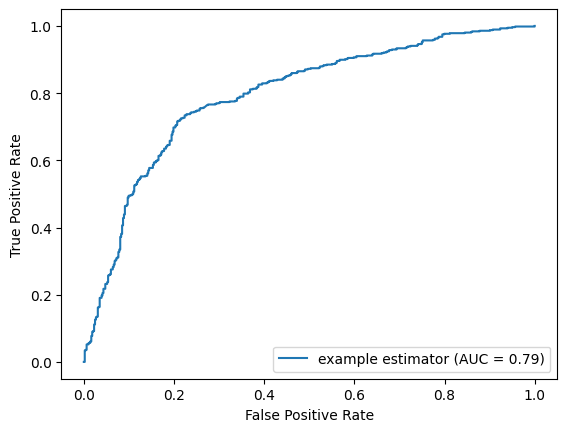

In [213]:
svm_model_rbf = SVC(C=1,gamma=0.1,kernel="rbf",cache_size=7000, probability=True)
svm_model_rbf.fit(X_train, y_train)
y_test_prob_svm_rbf = svm_model_rbf.predict_log_proba(X_test)
y = np.array(y_test.astype("int"))
pred = y_test_prob_svm_rbf[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

In [214]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.1,1,10], 'gamma': [0.1,1,10], 'kernel': ['linear']}

# Realizar la búsqueda de hiperparámetros con validación cruzada
grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Model fit.")

# Obtener los mejores parámetros y el mejor kernel encontrados
best_params = grid_search.best_params_
print(best_params)
best_kernel = best_params['kernel']
print("El mejor kernel encontrado es:", best_kernel)

Model fit.
{'C': 1, 'gamma': 0.1, 'kernel': 'linear'}
El mejor kernel encontrado es: linear


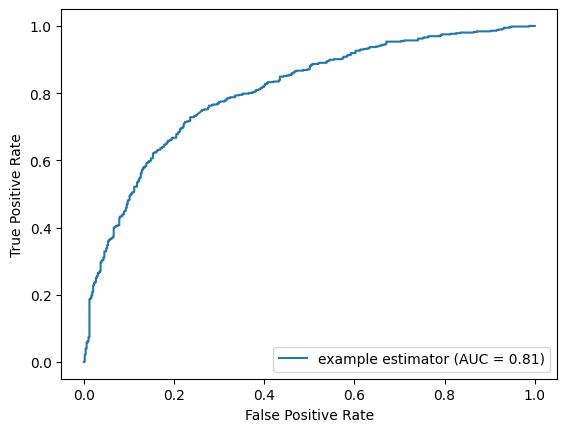

In [215]:
svm_model_linear = SVC(C=1,gamma=0.1,kernel="linear",cache_size=7000, probability=True)
svm_model_linear.fit(X_train, y_train)
y_test_prob_svm_linear = svm_model_linear.predict_log_proba(X_test)
y = np.array(y_test.astype("int"))
pred = y_test_prob_svm_linear[:,1]
fpr, tpr, thresholds = metrics.roc_curve(y, pred)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,
                                  estimator_name='example estimator')
display.plot()
plt.show()

Conclusión de kernels con SVM: La mejor accuracy es producida por el kernel rbf en el conjunto de train y test con los parámetros gamma = 4 y C = 4, mientras que con los parametros óptimos dados por GridSearch su accuracy se queda en el 0.74 tanto para test como train. (Buena noticia: no hace overfitting en ninguno de los 2 casos.) Por otro lado el kernel linear tanto con los parámetros de GridSearch como Validación Cruzada no sube su accuracy del 0.7.

In [336]:
from utils import evaluate_classification_metrics


In [337]:
modelos = [knn_model,logreg_model,lasso_model,ridge_model,elasticnet_model,randomforest_model,boosting,arbol_clasificador,bootstrap,svm_model_linear,svm_model_rbf]
metricas_modelos = {}
for model in modelos:
    metricas_model = evaluate_classification_metrics(y_test, model.predict(X_test), 1)
    metricas_model = {metrica: round(float(valor), 3) if isinstance(valor, (int, float)) else valor for metrica,valor in metricas_model.items()}
    metricas_modelos[type(model).__name__] = metricas_model
    
# Crear un DataFrame a partir de los diccionarios de métricas
df_metricas = pd.DataFrame(metricas_modelos).T

# Mostrar el DataFrame
print(df_metricas)


                                Confusion Matrix Accuracy Precision Recall  \
KNeighborsClassifier        [378, 146, 139, 376]    0.726      0.72   0.73   
LogisticRegression          [375, 149, 137, 378]    0.725     0.717  0.734   
Lasso                           [524, 0, 515, 0]    0.504       0.0    0.0   
Ridge                           [524, 0, 515, 0]    0.504       0.0    0.0   
ElasticNet                      [524, 0, 515, 0]    0.504       0.0    0.0   
RandomForestClassifier      [396, 128, 123, 392]    0.758     0.754  0.761   
GradientBoostingClassifier    [22, 502, 14, 501]    0.503       0.5  0.973   
DecisionTreeClassifier      [399, 125, 162, 353]    0.724     0.738  0.685   
BaggingClassifier           [381, 143, 139, 376]    0.729     0.724   0.73   
SVC                         [388, 136, 119, 396]    0.755     0.744  0.769   

                           Specificity F1 Score  
KNeighborsClassifier             0.721    0.725  
LogisticRegression               0.716   

In [305]:
# Especifica la ruta y el nombre del archivo CSV donde deseas guardar el DataFrame
ruta_archivo_csv = 'comparacion_metricas_modelos.csv'

# Guarda el DataFrame en un archivo CSV
df_metricas.to_csv(ruta_archivo_csv, index=False) 

## Unsupervised learning

En esta parte vamos a ver 2 técnicas en concreto:

    1. PCA
    
    2. Clustering

Nota: recordar que en unsupervised learning no se usa la columna output, aunque en este caso la tenemos no suele ser lo común


In [264]:
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cluster import KMeans
from sklearn.cluster import dbscan
# parte creativa: Gaussian
from sklearn.cluster import AgglomerativeClustering

### PCA

In [265]:
pca_model = PCA()
pca_model.fit(X_train)  

PCA()

In [266]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
import pandas as pd

# Escalar los datos si es necesario
X = scale(df[inputs])

# Aplicar PCA
pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

# Crear un DataFrame para los loadings
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'], index=df[inputs].columns)
loadings

PC1       PC2       PC3       PC4  \
ExternalRiskEstimate         -0.406782 -0.350650 -0.176171 -0.269021   
NetFractionRevolvingBurden    0.383036  0.279604  0.195298 -0.107952   
AverageMInFile               -0.319759 -0.049165  0.599985 -0.128576   
MSinceOldestTradeOpen        -0.343853  0.084139  0.554685 -0.125984   
PercentTradesWBalance         0.402677  0.164019  0.156963 -0.433966   
PercentInstallTrades          0.231377  0.107491 -0.059514 -0.581578   
NumSatisfactoryTrades        -0.295590  0.598851 -0.148906  0.006086   
NumTotalTrades               -0.275154  0.616564 -0.108418  0.023828   
PercentTradesNeverDelq       -0.263088 -0.015377 -0.447071 -0.387722   
MSinceMostRecentInqexcl7days -0.139101 -0.109097  0.034433 -0.453959   

                                   PC5       PC6       PC7       PC8  \
ExternalRiskEstimate         -0.181637 -0.099853 -0.179491  0.346209   
NetFractionRevolvingBurden    0.222518 -0.454005  0.483895  0.335967   
AverageMInFile               -0.117085 -0.081542 -0.046571  0.530050   
MSinceOldestTradeOpen        -0.128189 -0.097796  0.187705 -0.642519   
PercentTradesWBalance        -0.055456 -0.258038 -0.715738 -0.123679   
PercentInstallTrades         -0.461868  0.512742  0.336109  0.049305   
NumSatisfactoryTrades         0.026062  0.059015 -0.087878  0.123193   
NumTotalTrades                0.017032  0.117326 -0.126034  0.067803   
PercentTradesNeverDelq       -0.055296 -0.573310  0.217276 -0.185873   
MSinceMostRecentInqexcl7days  0.816657  0.303769  0.012648 -0.037846   

                                   PC9      PC10  
ExternalRiskEstimate          0.642069  0.029541  
NetFractionRevolvingBurden    0.350210 -0.000523  
AverageMInFile               -0.460779 -0.055018  
MSinceOldestTradeOpen         0.272526  0.052982  
PercentTradesWBalance         0.015685  0.022408  
PercentInstallTrades         -0.038498  0.005239  
NumSatisfactoryTrades        -0.005658  0.710423  
NumTotalTrades                0.125829 -0.693864  
PercentTradesNeverDelq       -0.400295 -0.081314  
MSinceMostRecentInqexcl7days -0.026158 -0.002081

In [267]:
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10'],index=df[inputs].columns)
loading_matrix

PC1       PC2       PC3       PC4  \
ExternalRiskEstimate         -0.699930 -0.477403 -0.216495 -0.275581   
NetFractionRevolvingBurden    0.659071  0.380676  0.239999 -0.110585   
AverageMInFile               -0.550193 -0.066937  0.737313 -0.131711   
MSinceOldestTradeOpen        -0.591651  0.114554  0.681645 -0.129056   
PercentTradesWBalance         0.692867  0.223309  0.192889 -0.444548   
PercentInstallTrades          0.398118  0.146348 -0.073136 -0.595759   
NumSatisfactoryTrades        -0.508607  0.815325 -0.182988  0.006235   
NumTotalTrades               -0.473443  0.839441 -0.133234  0.024409   
PercentTradesNeverDelq       -0.452683 -0.020936 -0.549399 -0.397176   
MSinceMostRecentInqexcl7days -0.239344 -0.148534  0.042314 -0.465028   

                                   PC5       PC6       PC7       PC8  \
ExternalRiskEstimate         -0.175776 -0.091606 -0.104156  0.175498   
NetFractionRevolvingBurden    0.215339 -0.416508  0.280797  0.170306   
AverageMInFile               -0.113307 -0.074807 -0.027025  0.268689   
MSinceOldestTradeOpen        -0.124053 -0.089719  0.108923 -0.325701   
PercentTradesWBalance        -0.053667 -0.236726 -0.415333 -0.062694   
PercentInstallTrades         -0.446966  0.470394  0.195039  0.024993   
NumSatisfactoryTrades         0.025221  0.054141 -0.050995  0.062448   
NumTotalTrades                0.016483  0.107636 -0.073136  0.034370   
PercentTradesNeverDelq       -0.053512 -0.525960  0.126082 -0.094221   
MSinceMostRecentInqexcl7days  0.790309  0.278680  0.007339 -0.019185   

                                   PC9      PC10  
ExternalRiskEstimate          0.280300  0.007572  
NetFractionRevolvingBurden    0.152887 -0.000134  
AverageMInFile               -0.201157 -0.014102  
MSinceOldestTradeOpen         0.118973  0.013580  
PercentTradesWBalance         0.006847  0.005744  
PercentInstallTrades         -0.016807  0.001343  
NumSatisfactoryTrades        -0.002470  0.182096  
NumTotalTrades                0.054931 -0.177852  
PercentTradesNeverDelq       -0.174752 -0.020842  
MSinceMostRecentInqexcl7days -0.011420 -0.000533

----------------------------------------------------
Porcentaje de varianza explicada por cada componente
----------------------------------------------------
[0.29644039 0.18802032 0.14989701 0.10387062 0.09412768 0.08383389
 0.03335035 0.02507905 0.01894065 0.00644006]


Text(0, 0.5, 'Por. varianza explicada')

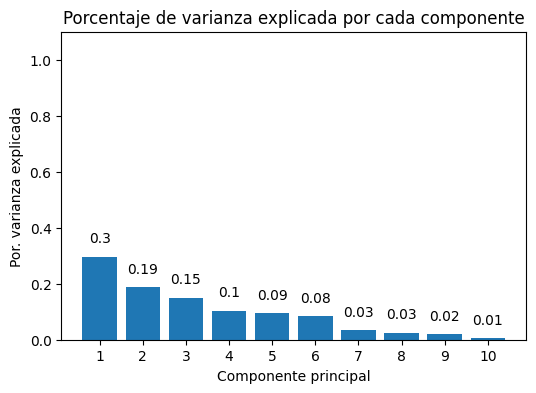

In [268]:
# Porcentaje de varianza explicada por cada componente
# ==============================================================================
print('----------------------------------------------------')
print('Porcentaje de varianza explicada por cada componente')
print('----------------------------------------------------')
print(pca_model.explained_variance_ratio_)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4))
ax.bar(
    x      = np.arange(pca_model.n_components_) + 1,
    height = pca_model.explained_variance_ratio_
)

for x, y in zip(np.arange(len(df[inputs].columns)) + 1, pca_model.explained_variance_ratio_):
    label = round(y, 2)
    ax.annotate(
        label,
        (x,y),
        textcoords="offset points",
        xytext=(0,10),
        ha='center'
    )

ax.set_xticks(np.arange(pca_model.n_components_) + 1)
ax.set_ylim(0, 1.1)
ax.set_title('Porcentaje de varianza explicada por cada componente')
ax.set_xlabel('Componente principal')
ax.set_ylabel('Por. varianza explicada')

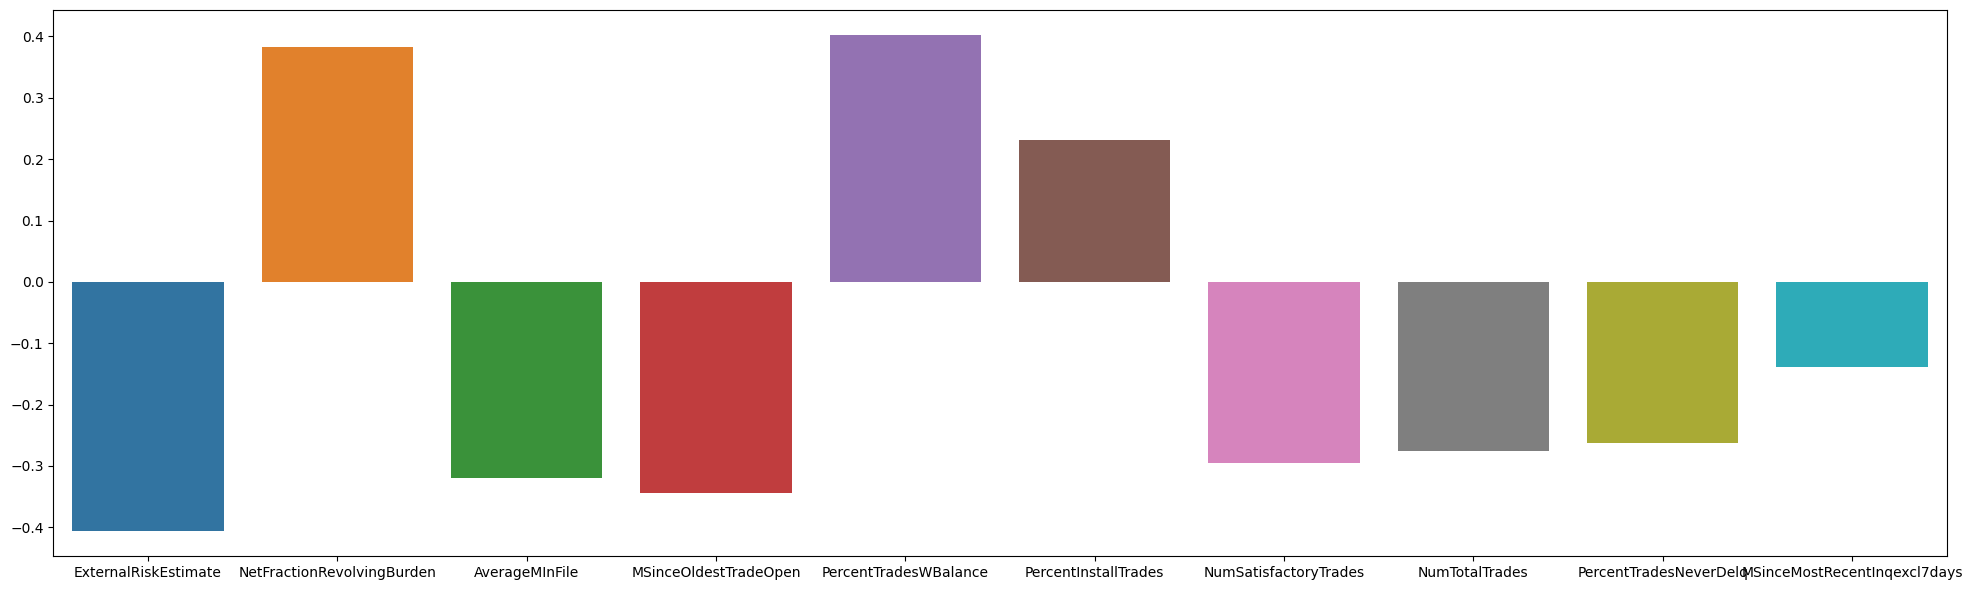

In [275]:
plt.figure(figsize=(20,6))
sns.barplot(x = df[inputs].columns, y = pca.components_[0])
plt.tight_layout()
plt.show()

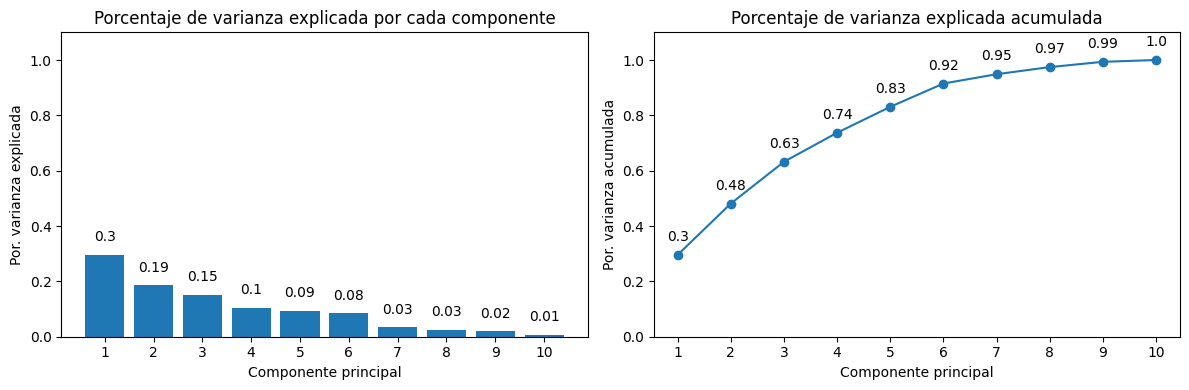

In [308]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Gráfico de barras para el porcentaje de varianza explicada por cada componente
ax1.bar(
    x=np.arange(pca.n_components_) + 1,
    height=pca.explained_variance_ratio_
)
for x, y in zip(np.arange(len(df[inputs].columns)) + 1, pca.explained_variance_ratio_):
    label = round(y, 2)
    ax1.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
)
ax1.set_xticks(np.arange(pca.n_components_) + 1)
ax1.set_ylim(0, 1.1)
ax1.set_title('Porcentaje de varianza explicada por cada componente')
ax1.set_xlabel('Componente principal')
ax1.set_ylabel('Por. varianza explicada')

# Gráfico de línea para el porcentaje de varianza explicada acumulada
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
ax2.plot(
    np.arange(len(df[inputs].columns)) + 1,
    prop_varianza_acum,
    marker='o'
)
for x, y in zip(np.arange(len(df[inputs].columns)) + 1, prop_varianza_acum):
    label = round(y, 2)
    ax2.annotate(
        label,
        (x, y),
        textcoords="offset points",
        xytext=(0, 10),
        ha='center'
)
ax2.set_ylim(0, 1.1)
ax2.set_xticks(np.arange(pca.n_components_) + 1)
ax2.set_title('Porcentaje de varianza explicada acumulada')
ax2.set_xlabel('Componente principal')
ax2.set_ylabel('Por. varianza acumulada')

plt.tight_layout()
plt.show()


<AxesSubplot: >

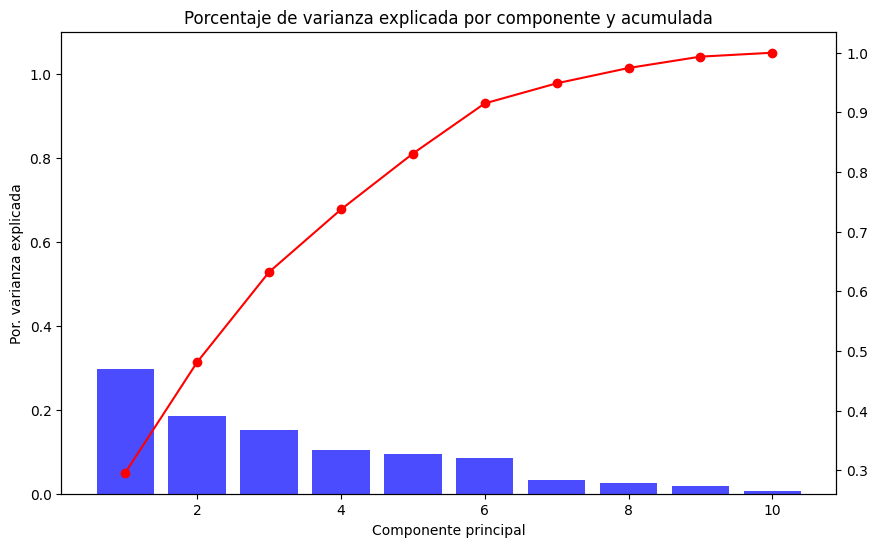

In [309]:
fig, ax1 = plt.subplots(figsize=(10, 6))

# Gráfico de barras para el porcentaje de varianza explicada por cada componente
ax1.bar(
    x=np.arange(pca.n_components_) + 1,
    height=pca.explained_variance_ratio_,
    color='b',
    alpha=0.7,
    label='Varianza explicada por componente'
)

ax1.set_xlabel('Componente principal')
ax1.set_ylabel('Por. varianza explicada')
ax1.set_ylim(0, 1.1)
ax1.set_title('Porcentaje de varianza explicada por componente y acumulada')

# Gráfico de línea para el porcentaje de varianza explicada acumulada
ax2 = ax1.twinx()
prop_varianza_acum = pca.explained_variance_ratio_.cumsum()
ax2.plot(
    np.arange(len(df[inputs].columns)) + 1,
    prop_varianza_acum,
    color='r',
    marker='o',
    label='Varianza explicada acumulada'
)
ax2


Esto nos da a entender que las ultimas 4 componentes apenas aportan nada a la explicación de los datos y el analisis de los tipos de clientes que tenemos, por tanto es muy posibles que podamos eliminarlas.

In [155]:
# Aplicar PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(df[inputs])

# Crear un nuevo DataFrame con las componentes principales
principal_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])

# Graficar las componentes principales
plt.figure()
plt.scatter(principal_df['PC1'], principal_df['PC2'], c=np.where(principal_df['PC1'] > 0, '#CC66FF', '#FF66CC'))
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal Components of PCA')
plt.show()

### Clustering

In [157]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### K-Means

#### Método del codo

In [159]:
# Método elbow para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
                        n_clusters   = n_clusters, 
                        n_init       = 20, 
                        random_state = 123
                    )
    modelo_kmeans.fit_transform(df[inputs])
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)')

Text(0, 0.5, 'Intra-cluster (inertia)')

Como podemos observar, el pico de nuestra función está en k = 2, este es nuestro parámetro óptimo de clusters. Ahora procederemos a entrenar el modelo con dicho parámetro.

In [165]:
kmeans = KMeans(n_clusters=2,init="k-means++",random_state=42)
kmeans.fit(df[inputs])

C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2, random_state=42)

In [166]:
# obtención de los cluters con sus centroides
labels = kmeans.labels_
centroides = kmeans.cluster_centers_
X_pca = pca.fit_transform(df[inputs])
centroides = pca.transform(centroides)
plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=50, cmap="viridis")
plt.scatter(centroides[:,0], centroides[:,1], marker="x", s=200, c="red")
plt.xlabel("Grupos")
plt.ylabel("Datos")
plt.title("Centrodies de los grupos obtenidos por K-Means con k óptimo")
plt.show()

C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


#### Método de la silueta


C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2 The average silhouette_score is : 0.44864881576650123


C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3 The average silhouette_score is : 0.31674026747917955


C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4 The average silhouette_score is : 0.2867597999040852


C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5 The average silhouette_score is : 0.2566855902502116


C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6 The average silhouette_score is : 0.23374733260529523


C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


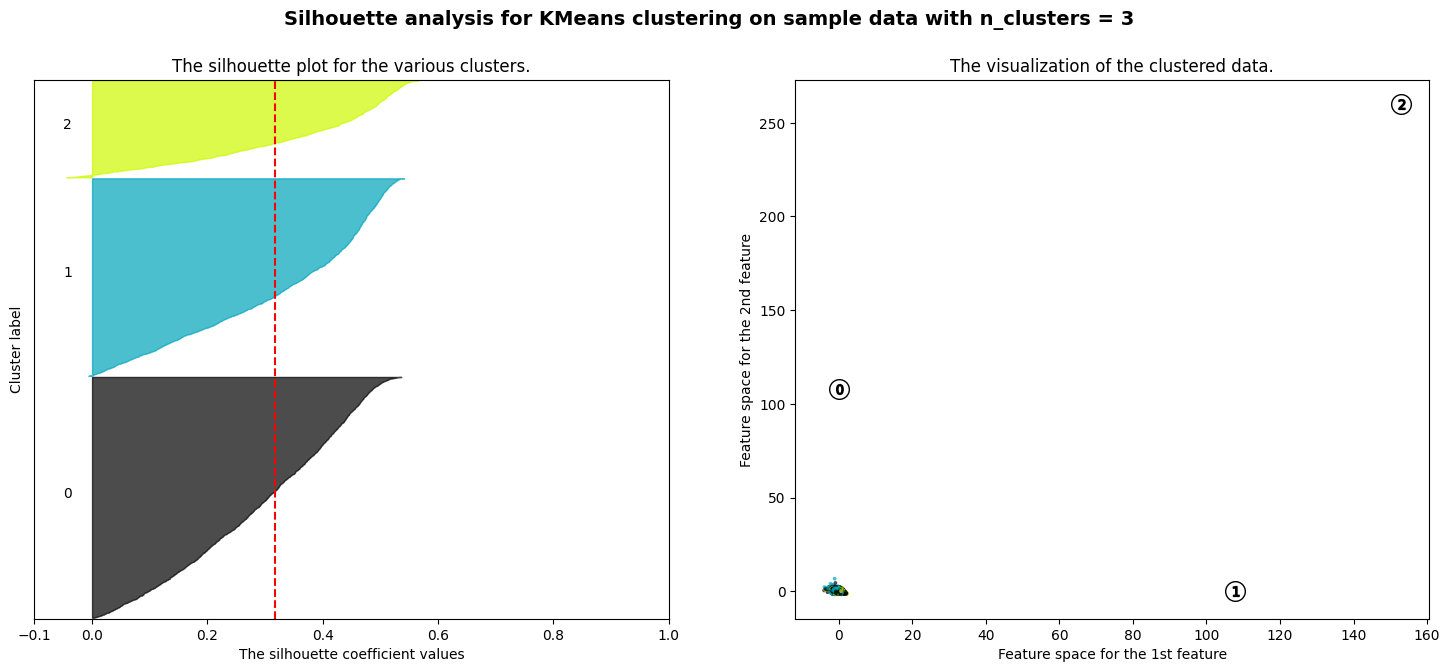

In [170]:
import matplotlib.cm as cm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(df[inputs]) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(df[inputs])

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(df[inputs], cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(df[inputs], cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    centers = clusterer.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [48]:
silhouette_scores = []
for k in range(2,11):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df[inputs])
    score = silhouette_score(df[inputs], kmeans.labels_)
    silhouette_scores.append(score)

plt.plot(range(2,11), silhouette_scores, marker="o")
plt.xlabel("Número de clusters (k)")
plt.ylabel("Coeficientes de la silueta.")
plt.title("Coeficientes de la silueta en función de k")
plt.show()

C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set

#### Árboles Jerárquicos

In [49]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

In [52]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''
    
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

In [53]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'complete',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_complete.fit(X=df[inputs])

modelo_hclust_average = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'average',
                            distance_threshold = 0,
                            n_clusters         = None
                        )
modelo_hclust_average.fit(X=df[inputs])

modelo_hclust_ward = AgglomerativeClustering(
                            affinity = 'euclidean',
                            linkage  = 'ward',
                            distance_threshold = 0,
                            n_clusters         = None
                     )
modelo_hclust_ward.fit(X=df[inputs])

C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(
C:\Users\meryg\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_agglomerative.py:1006: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


AgglomerativeClustering(affinity='euclidean', distance_threshold=0,
                        n_clusters=None)

In [310]:
# Dendrogramas
# ==============================================================================
fig, axs = plt.subplots(3, 1, figsize=(8, 5))
plot_dendrogram(modelo_hclust_average, color_threshold=0, ax=axs[0])
axs[0].set_title("Distancia euclídea, Linkage average")
plot_dendrogram(modelo_hclust_complete, color_threshold=0, ax=axs[1])
axs[1].set_title("Distancia euclídea, Linkage complete")
plot_dendrogram(modelo_hclust_ward, color_threshold=0, ax=axs[2])
axs[2].set_title("Distancia euclídea, Linkage ward")
plt.tight_layout()

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 6000
plot_dendrogram(modelo_hclust_ward, color_threshold=altura_corte, ax=ax)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend()

#### Innovación: Gaussian mixture

In [311]:
from sklearn.mixture import GaussianMixture
import matplotlib

In [88]:
modelo_gmm = GaussianMixture(n_components=10, covariance_type='full', random_state=123)
modelo_gmm.fit(X=df[inputs])

GaussianMixture(n_components=10, random_state=123)

In [317]:
# ==============================================================================
modelo_gmm = GaussianMixture(n_components=4, covariance_type='full', random_state=123)
modelo_gmm.fit(X=X)
# Media de cada componente
media_comps = modelo_gmm.means_
# Matriz de covarianza de cada componente
cov_comps = modelo_gmm.covariances_
# Probabilidades
probabilidades = modelo_gmm.predict_proba(X)
# Clasificación (asignación a la componente de mayor probabilidad)
clasificacion = modelo_gmm.predict(X)

def make_ellipses(gmm, ax, i):
    if gmm.covariance_type == 'full':
        covariances = gmm.covariances_[i]
    elif gmm.covariance_type == 'tied':
        covariances = gmm.covariances_
    elif gmm.covariance_type == 'diag':
        covariances = np.diag(gmm.covariances_[i])
    elif gmm.covariance_type == 'spherical':
        covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[i]
    v, w = np.linalg.eigh(covariances)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan2(u[1], u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    v = 2. * np.sqrt(2.) * np.sqrt(v)

    for j in range(1, 3):
        ell = matplotlib.patches.Ellipse(gmm.means_[i], j * v[0], j * v[1],
                                         180 + angle, color="blue")
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.1)
        ax.add_artist(ell)


fig, axs = plt.subplots(5, 2, figsize=(10, 10))

for i, ax in enumerate(axs.flatten()):
    ax.scatter(
        x=X_pca[clasificacion == i, 0],
        y=X_pca[clasificacion == i, 1],
        c=plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker='o',
        edgecolor='black',
        label=f"Componente {i}"
    )
    make_ellipses(modelo_gmm, ax, i)
    ax.set_title(f'Componente {i}')
    ax.legend()

plt.tight_layout()
plt.show()


C:\Users\meryg\AppData\Local\Temp\ipykernel_15160\1048990825.py:21: MatplotlibDeprecationWarning: Passing the angle parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  ell = matplotlib.patches.Ellipse(gmm.means_[i], j * v[0], j * v[1],
